In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest

In [5]:
pd.set_option('display.max_columns', None)


ddos = pd.read_csv('DDoS.csv')
ddos

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,3,3413,3665,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104340,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,10,29,2842,0,0,ICMP,1,15209,12720,1,1.0,2.0,0
104341,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,10,29,2842,0,0,ICMP,3,15099,14693,1,1.0,2.0,0
104342,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,0,ICMP,2,3409,3731,0,0.0,0.0,0
104343,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,0,ICMP,1,15209,12720,1,1.0,2.0,0


In [6]:
ddos['tx_bytes'].max()

1269981973

In [7]:
ddos['label'].value_counts()

0    63561
1    40784
Name: label, dtype: int64

In [8]:
def mid_factors(x):
    factor = []
    for i in range(1, x + 1):
        if x % i == 0:
            factor.append(i)
    length = len(factor)
    if length % 2 == 0:
        return factor[length//2], factor[length//2 - 1]
    else:
        return factor[length//2], factor[length//2]

def plot_cat_vs_label(data, columns, method = 'default'):
    length = len(columns)
    if length == 1:
        list = []
        column = columns[0]
        for i in data[column].sort_values().unique():
            list.append([i, data[(data[column] == i) & (data['label'] == 0)]['label'].count(), data[(data[column] == i) & (data['label'] == 1)]['label'].count()])
        
        df = pd.DataFrame(np.array(list), columns=[column, 'benign', 'malicious'])
        df['benign'] = df['benign'].astype('int64')
        df['malicious'] = df['malicious'].astype('int64')
        df = df.set_index(column)
        if method == 'pie':
            fig, ax = plt.subplots(1,1,figsize=(10,10))
            ax.pie(df['malicious'], labels = df.index, startangle=90, autopct='%.1f%%', textprops={'fontsize': 15})
            ax.set_title('Malicious Switch Pie Plot', fontsize=20)
            ax.legend(df.index)
            return
        fig, ax = plt.subplots(1,1,figsize=(20,8))
        ax.bar(np.arange(len(df.index))-0.2, df["benign"], 0.4, label="benign")
        ax.bar(np.arange(len(df.index))+0.2, df["malicious"], 0.4, label="malicious")
        ax.set_xticks(np.arange(len(df.index)), df.index)
        ax.set_xlabel(column)
        ax.set_ylabel("Number")
        ax.set_title("Benign vs Malicious")
        ax.legend()
        return
    x, y = mid_factors(length)
    if method == 'pie':
        fig, axes = plt.subplots(y,x,figsize=(10*x,10*y))
    else:
        fig, axes = plt.subplots(x,y,figsize=(20*y,8*x))
    axes = axes.ravel()
    for column, ax in zip(columns, axes):
        list = []
        for i in data[column].sort_values().unique():
            list.append([i, data[(data[column] == i) & (data['label'] == 0)]['label'].count(), data[(data[column] == i) & (data['label'] == 1)]['label'].count()])

        df = pd.DataFrame(np.array(list), columns=[column, 'benign', 'malicious'])
        df['benign'] = df['benign'].astype('int64')
        df['malicious'] = df['malicious'].astype('int64')
        df = df.set_index(column)

        if method == 'pie':
            ax.pie(df['malicious'], labels = df.index, startangle=90, autopct='%.1f%%', textprops={'fontsize': 10})
            ax.set_title('Malicious Switch Pie Plot', fontsize=15)
            ax.legend(df.index)
            continue
        ax.bar(np.arange(len(df.index))-0.2, df["benign"], 0.4, label="benign")
        ax.bar(np.arange(len(df.index))+0.2, df["malicious"], 0.4, label="malicious")
        ax.set_xticks(np.arange(len(df.index)), df.index)
        ax.set_xlabel(column)
        ax.set_ylabel("Number")
        ax.set_title("Benign vs Malicious")
        ax.legend()
    plt.show()

In [9]:
#check null value:


#consider dropping these rows:
ddos_dp = ddos.dropna(subset=['rx_kbps', 'tot_kbps'])

In [10]:
ddos.isnull().any(axis=1)

0         False
1         False
2         False
3         False
4         False
          ...  
104340    False
104341    False
104342    False
104343    False
104344    False
Length: 104345, dtype: bool

In [11]:

cut_line = np.linspace(0, ddos_dp.shape[0], 6, dtype=int)
rx_bytes_sorted = ddos_dp['rx_bytes'].sort_values(ascending=True).to_numpy()
separator = [rx_bytes_sorted[cut_line[1]], rx_bytes_sorted[cut_line[2]], rx_bytes_sorted[cut_line[3]], rx_bytes_sorted[cut_line[4]]]
def separate(seperator, series):
    list = []
    for value in series:
        if value <= separator[0]:
            list.append(1)
        elif value <= separator[1]:
            list.append(2)
        elif value <= separator[2]:
            list.append(3)
        elif value <= separator[3]:
            list.append(4)
        else:
            list.append(5)
    return list

ddos_dp['rx_bytes_cat'] = separate(separator, ddos_dp['rx_bytes'])

cut_line = np.linspace(0, ddos_dp.shape[0], 6, dtype=int)
tx_bytes_sorted = ddos_dp['tx_bytes'].sort_values(ascending=True).to_numpy()
separator = [tx_bytes_sorted[cut_line[1]], tx_bytes_sorted[cut_line[2]], tx_bytes_sorted[cut_line[3]], tx_bytes_sorted[cut_line[4]]]
ddos_dp['tx_bytes_cat'] = separate(separator, ddos_dp['tx_bytes'])
ddos_dp

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label,rx_bytes_cat,tx_bytes_cat
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,UDP,3,143928631,3917,0,0.0,0.0,0,2,4
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,451,0,UDP,4,3842,3520,0,0.0,0.0,0,2,1
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,1,3795,1242,0,0.0,0.0,0,1,1
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,2,3688,1492,0,0.0,0.0,0,1,1
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,3,3413,3665,0,0.0,0.0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104340,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,10,29,2842,0,0,ICMP,1,15209,12720,1,1.0,2.0,0,2,2
104341,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,10,29,2842,0,0,ICMP,3,15099,14693,1,1.0,2.0,0,2,2
104342,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,0,ICMP,2,3409,3731,0,0.0,0.0,0,2,1
104343,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,0,ICMP,1,15209,12720,1,1.0,2.0,0,2,2


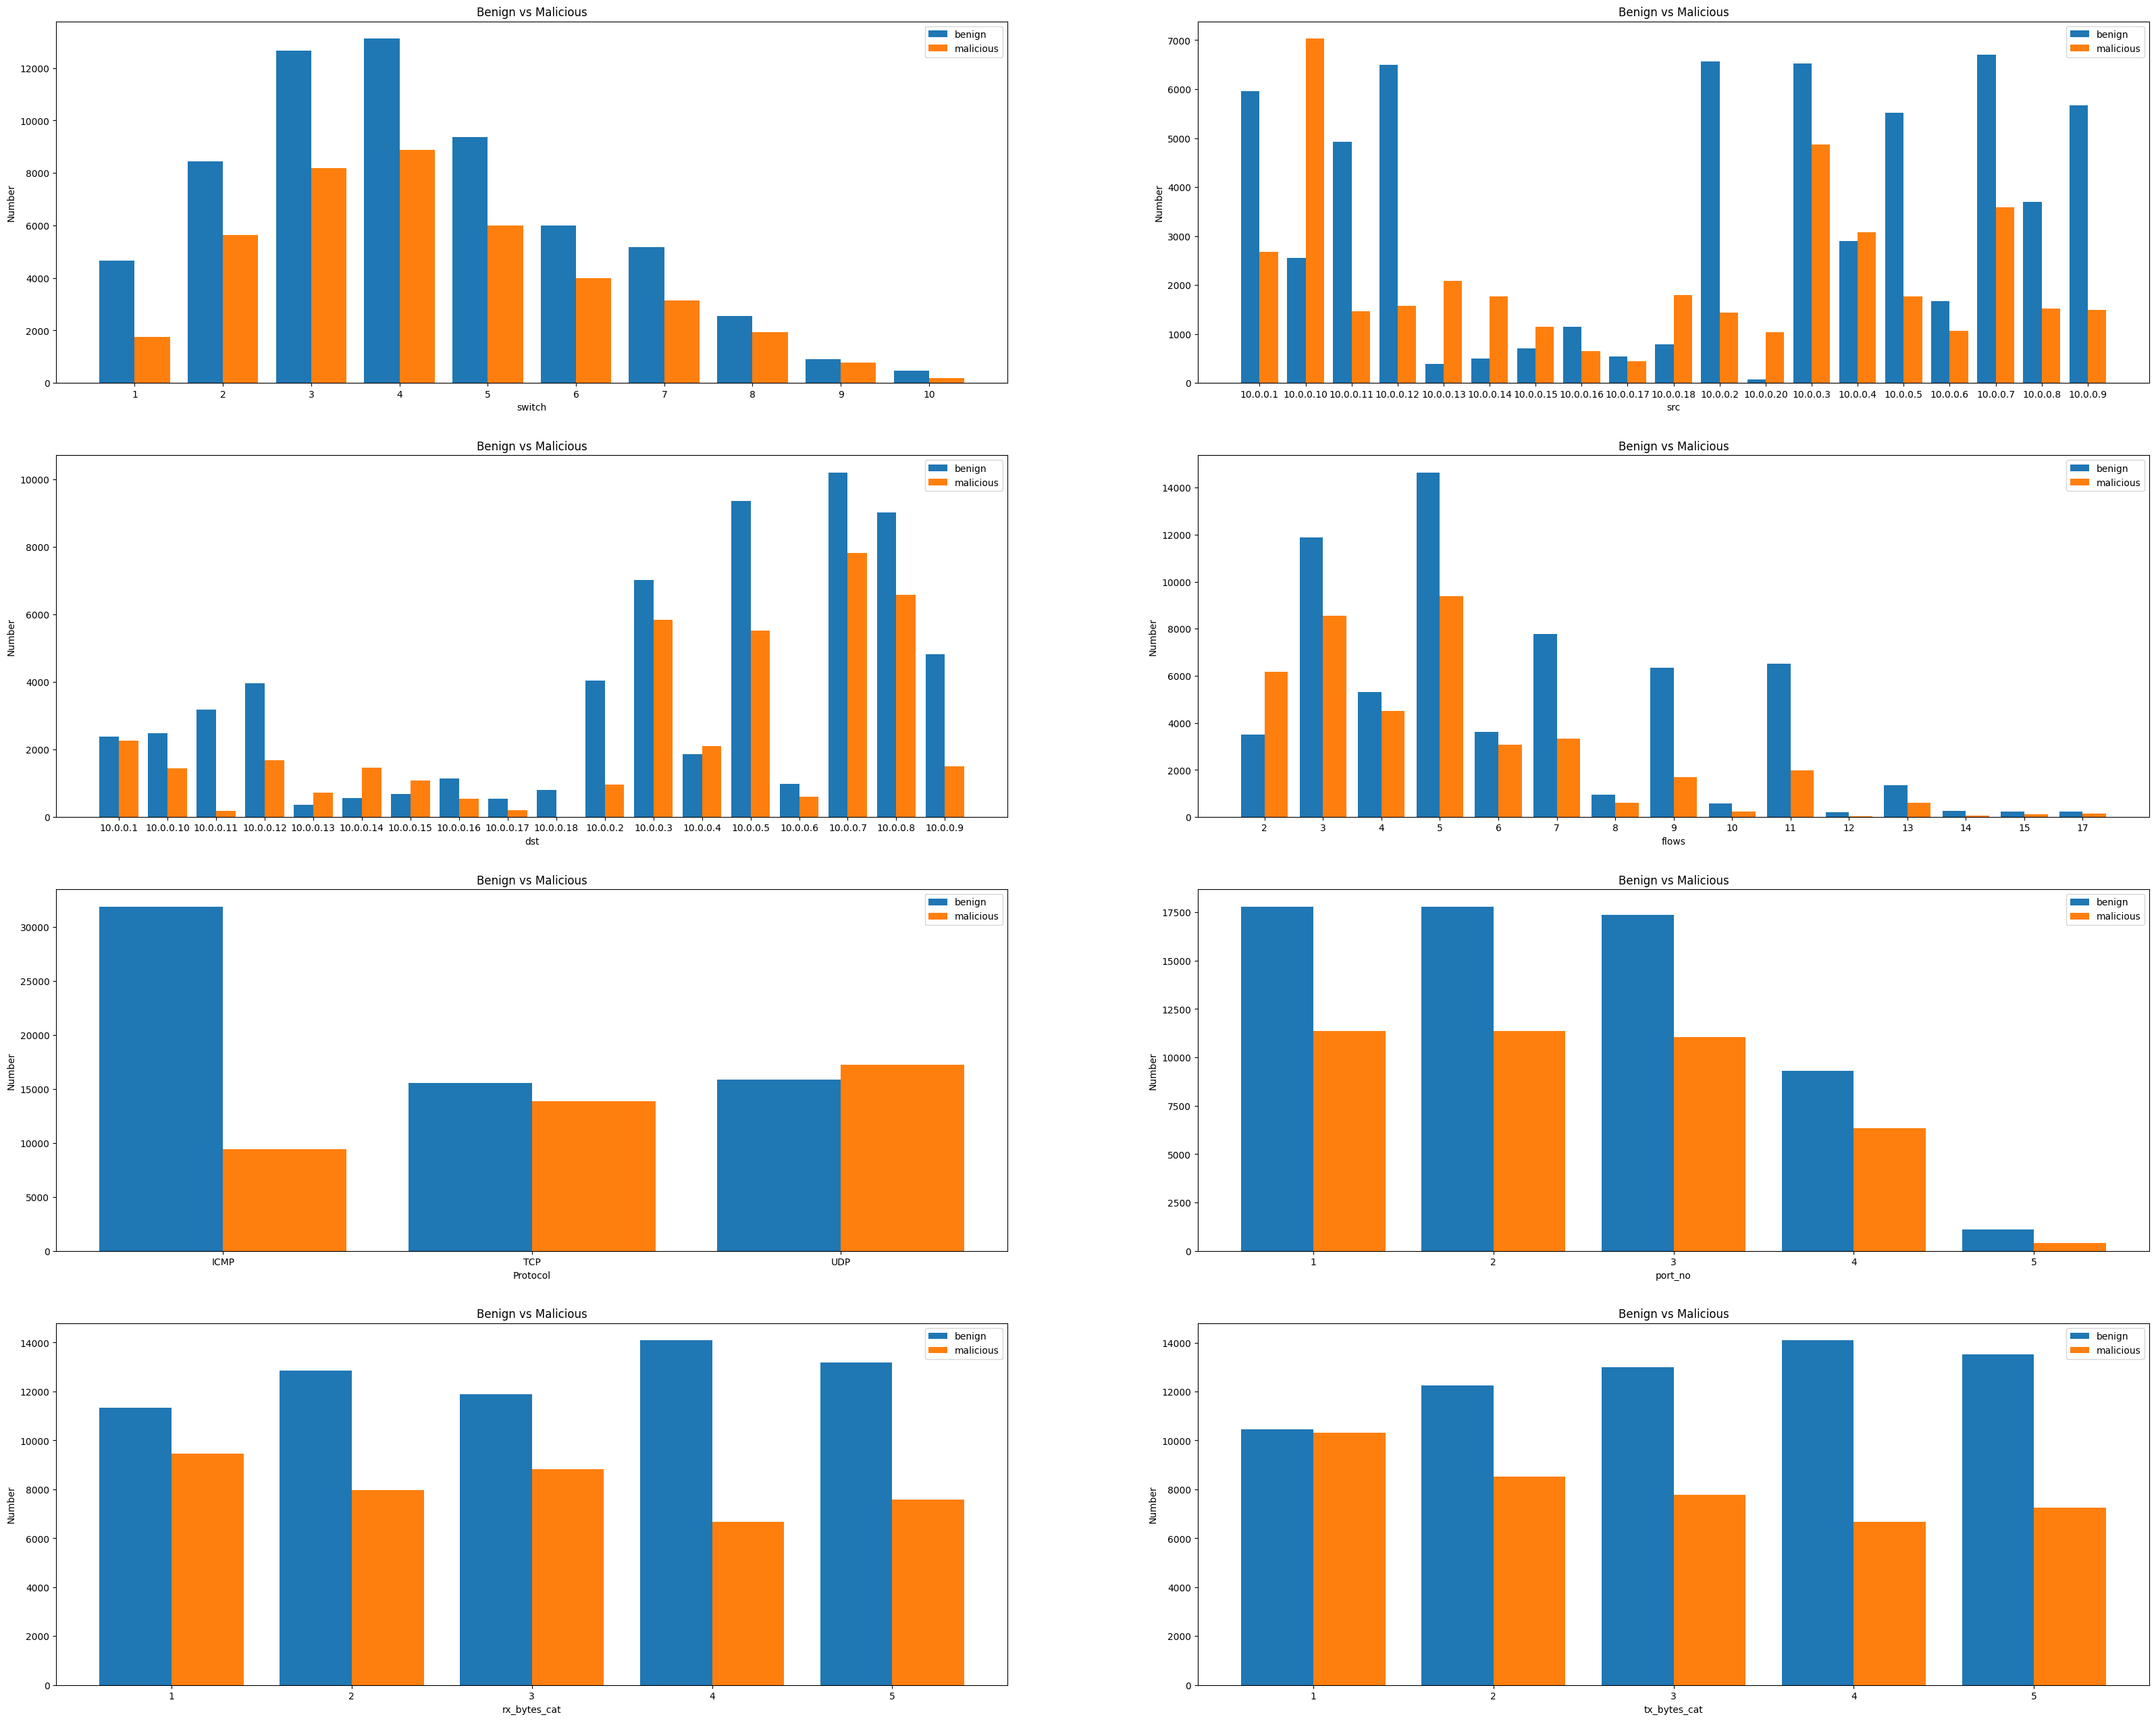

In [16]:
plot_cat_vs_label(ddos_dp, ['switch', 'src', 'dst', 'flows', 'Protocol', 'port_no', 'rx_bytes_cat', 'tx_bytes_cat'])

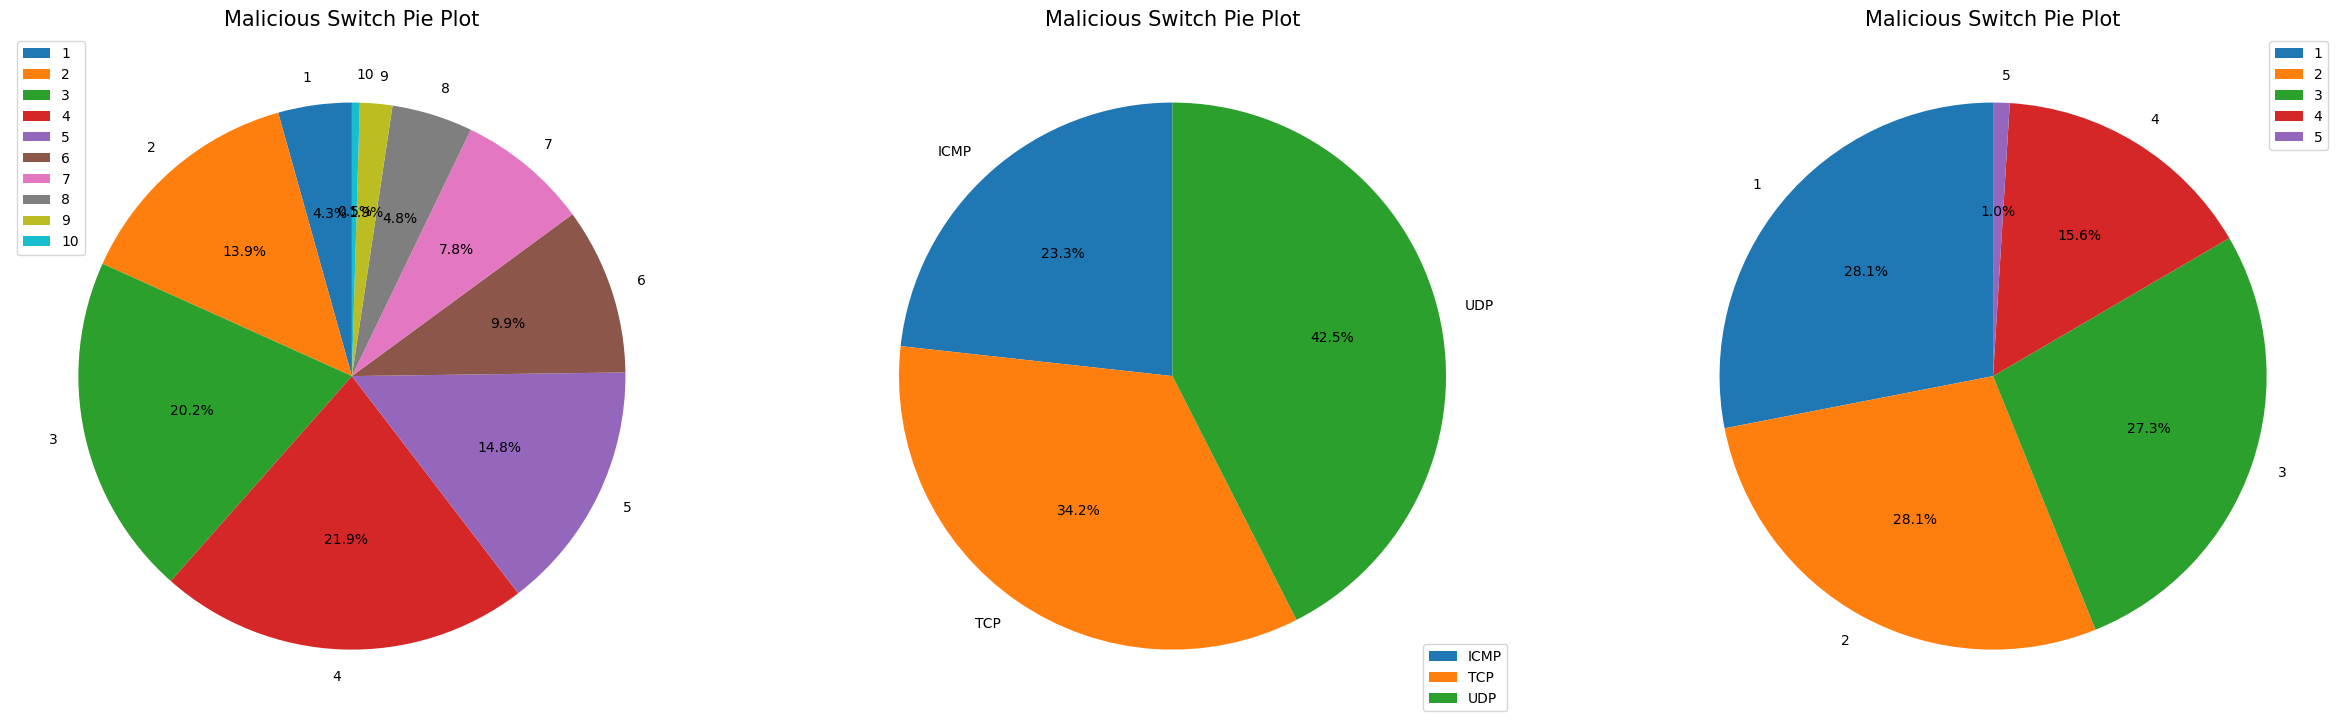

In [17]:
plot_cat_vs_label(ddos_dp, ['switch', 'Protocol', 'port_no'], 'pie')


In [12]:
ddos_dp.describe()

,dt,switch,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label,rx_bytes_cat,tx_bytes_cat
count,103839.000000,103839.000000,103839.000000,1.038390e+05,103839.000000,1.038390e+05,1.038390e+05,103839.000000,103839.000000,103839.000000,1.038390e+05,103839.000000,103839.000000,103839.000000,1.038390e+05,1.038390e+05,103839.000000,103839.000000,103839.000000,103839.000000,103839.000000,103839.000000
mean,17999.454165,4.214496,52781.703165,3.801729e+07,322.126118,4.613734e+08,3.225151e+11,5.666339,5196.261308,6365.870588,4.689472e+06,211.682248,0.603916,2.337580,9.370704e+07,9.373492e+07,1003.767322,1003.811420,2007.578742,0.390065,2.999249,2.999904
std,11962.227566,1.956320,52061.409178,4.874544e+07,283.926141,2.771020e+08,2.838104e+11,2.951013,5266.631950,7413.263909,7.562023e+06,247.138265,0.489085,1.082973,1.521679e+08,1.331642e+08,2428.363391,2054.887034,3144.437173,0.487767,1.414486,1.414234
min,2488.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.000000,4.000000,-130933.000000,-1.464426e+08,-4365.000000,0.000000,1.000000,2.527000e+03,8.560000e+02,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,7128.000000,3.000000,801.000000,7.928200e+04,128.000000,2.330000e+08,1.280000e+11,3.000000,1943.000000,29.000000,2.842000e+03,0.000000,0.000000,1.000000,4.799000e+03,3.539000e+03,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000
50%,11965.000000,4.000000,42557.000000,6.409692e+06,252.000000,4.180000e+08,2.520000e+11,5.000000,3024.000000,8304.000000,5.447360e+05,276.000000,1.000000,2.000000,4.552643e+06,1.401134e+07,0.000000,0.000000,4.000000,0.000000,3.000000,3.000000
75%,29982.000000,5.000000,94683.000000,7.597222e+07,413.000000,7.040000e+08,4.130000e+11,7.000000,7385.000000,10004.000000,9.727070e+06,333.000000,1.000000,3.000000,1.356509e+08,1.439286e+08,255.000000,557.000000,3838.000000,1.000000,4.000000,4.000000
max,42935.000000,10.000000,260006.000000,1.471280e+08,1881.000000,9.990000e+08,1.880000e+12,17.000000,25224.000000,19190.000000,1.495387e+07,639.000000,1.000000,5.000000,1.269982e+09,9.905962e+08,20580.000000,16577.000000,20580.000000,1.000000,5.000000,5.000000


array([[<AxesSubplot: xlabel='dt', ylabel='dt'>,
        <AxesSubplot: xlabel='pktcount', ylabel='dt'>,
        <AxesSubplot: xlabel='bytecount', ylabel='dt'>,
        <AxesSubplot: xlabel='dur', ylabel='dt'>,
        <AxesSubplot: xlabel='tx_bytes', ylabel='dt'>],
       [<AxesSubplot: xlabel='dt', ylabel='pktcount'>,
        <AxesSubplot: xlabel='pktcount', ylabel='pktcount'>,
        <AxesSubplot: xlabel='bytecount', ylabel='pktcount'>,
        <AxesSubplot: xlabel='dur', ylabel='pktcount'>,
        <AxesSubplot: xlabel='tx_bytes', ylabel='pktcount'>],
       [<AxesSubplot: xlabel='dt', ylabel='bytecount'>,
        <AxesSubplot: xlabel='pktcount', ylabel='bytecount'>,
        <AxesSubplot: xlabel='bytecount', ylabel='bytecount'>,
        <AxesSubplot: xlabel='dur', ylabel='bytecount'>,
        <AxesSubplot: xlabel='tx_bytes', ylabel='bytecount'>],
       [<AxesSubplot: xlabel='dt', ylabel='dur'>,
        <AxesSubplot: xlabel='pktcount', ylabel='dur'>,
        <AxesSubplot: xlabel='b

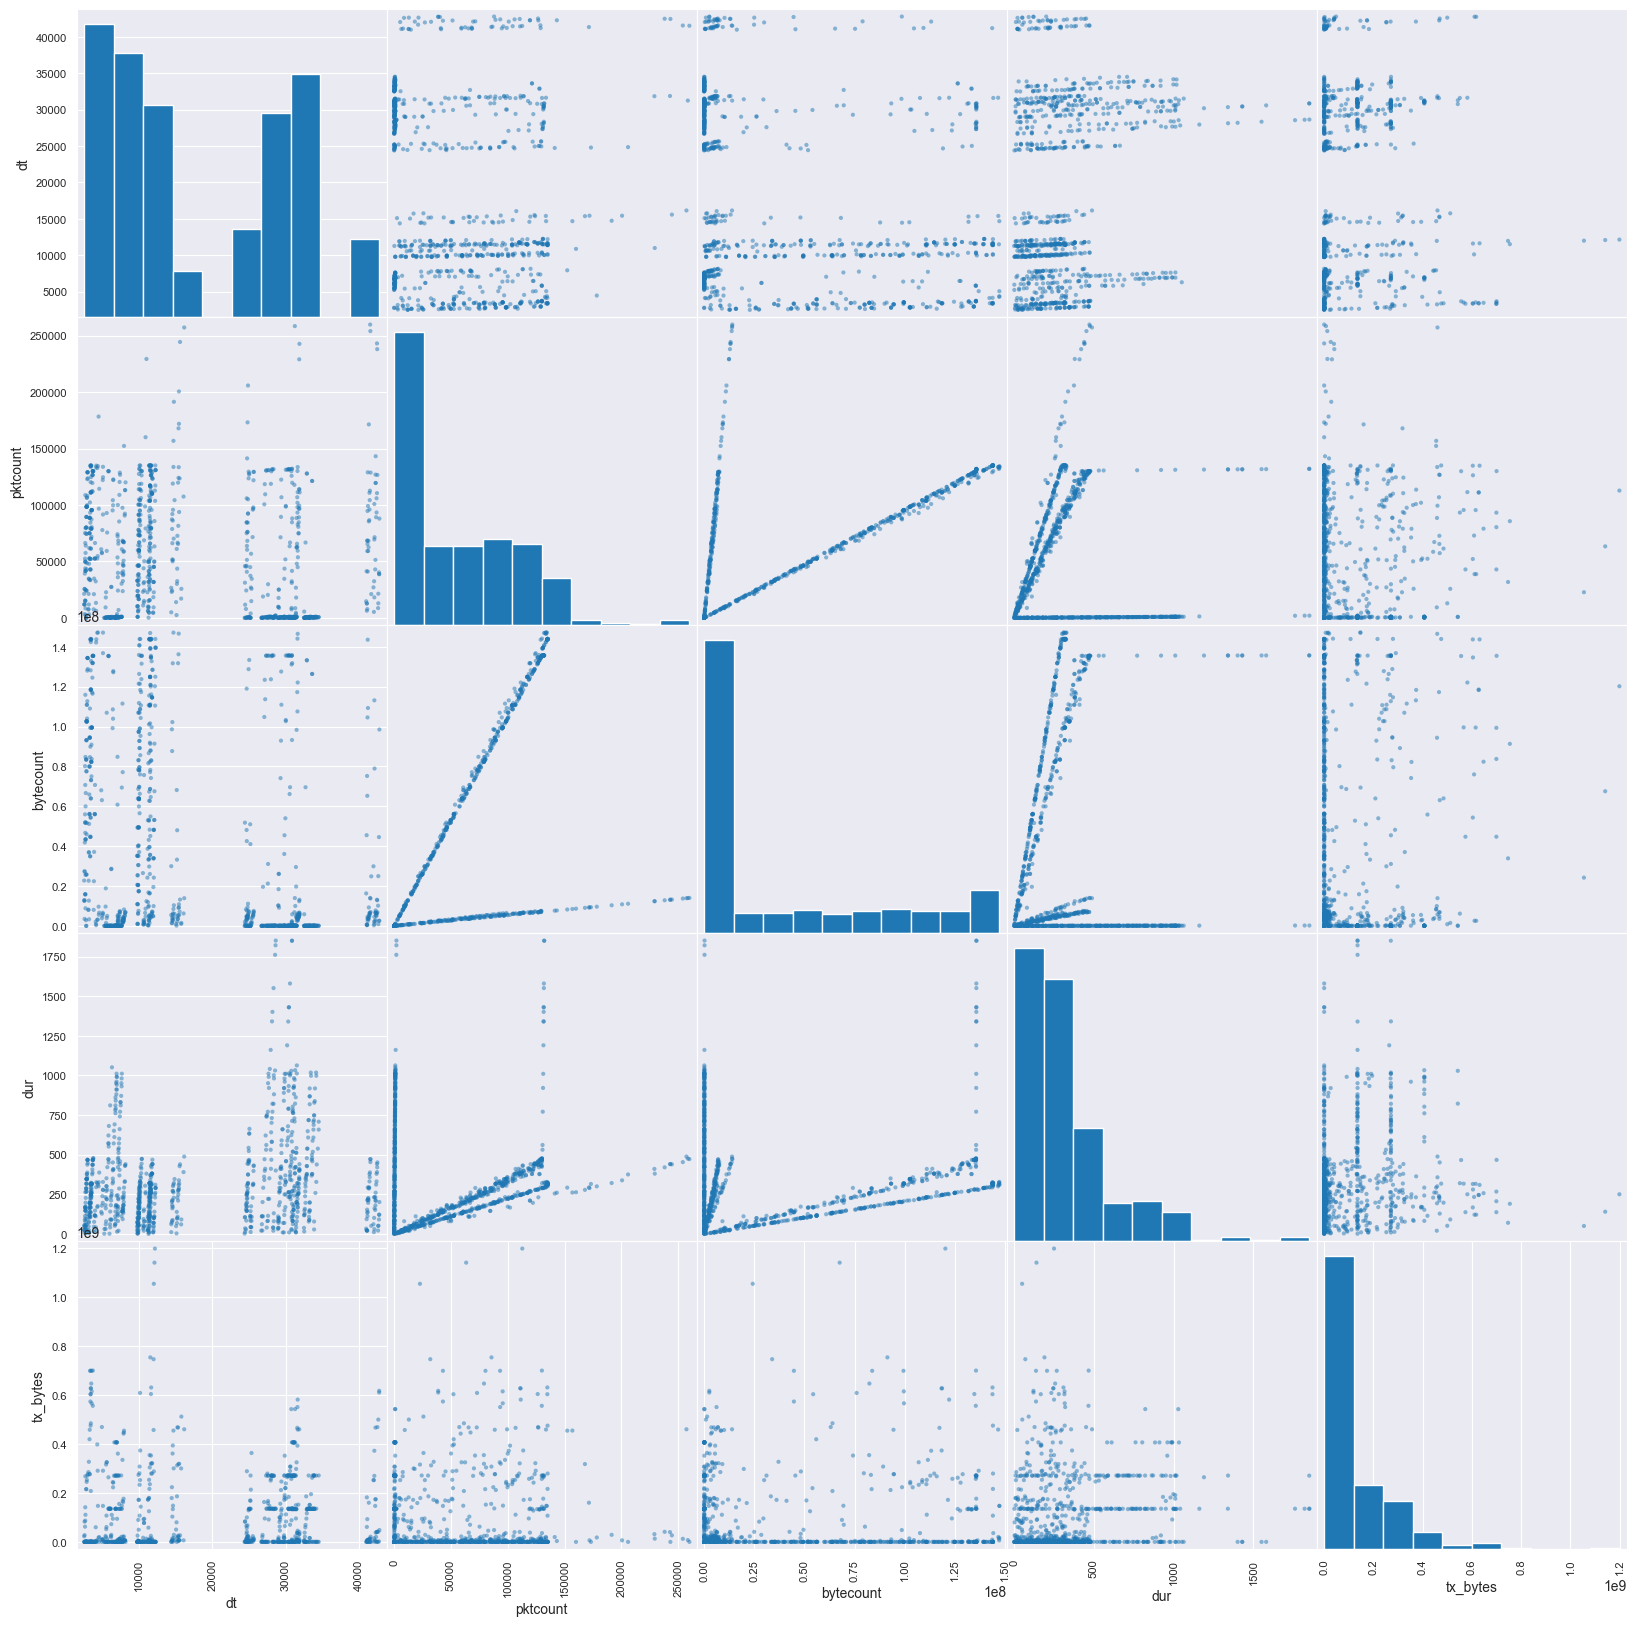

In [13]:
pd.plotting.scatter_matrix(ddos_dp[['dt', 'pktcount', 'bytecount', 'dur', 'tx_bytes']].sample(n=1000, random_state=42), alpha=.5, figsize=(20,20))

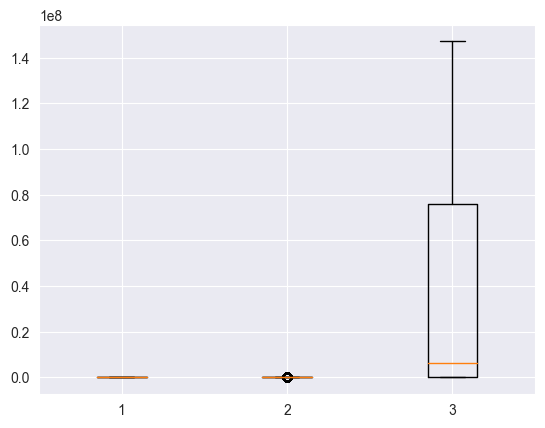

In [14]:
plt.boxplot(ddos_dp[['dt', 'pktcount', 'bytecount']])
plt.show()

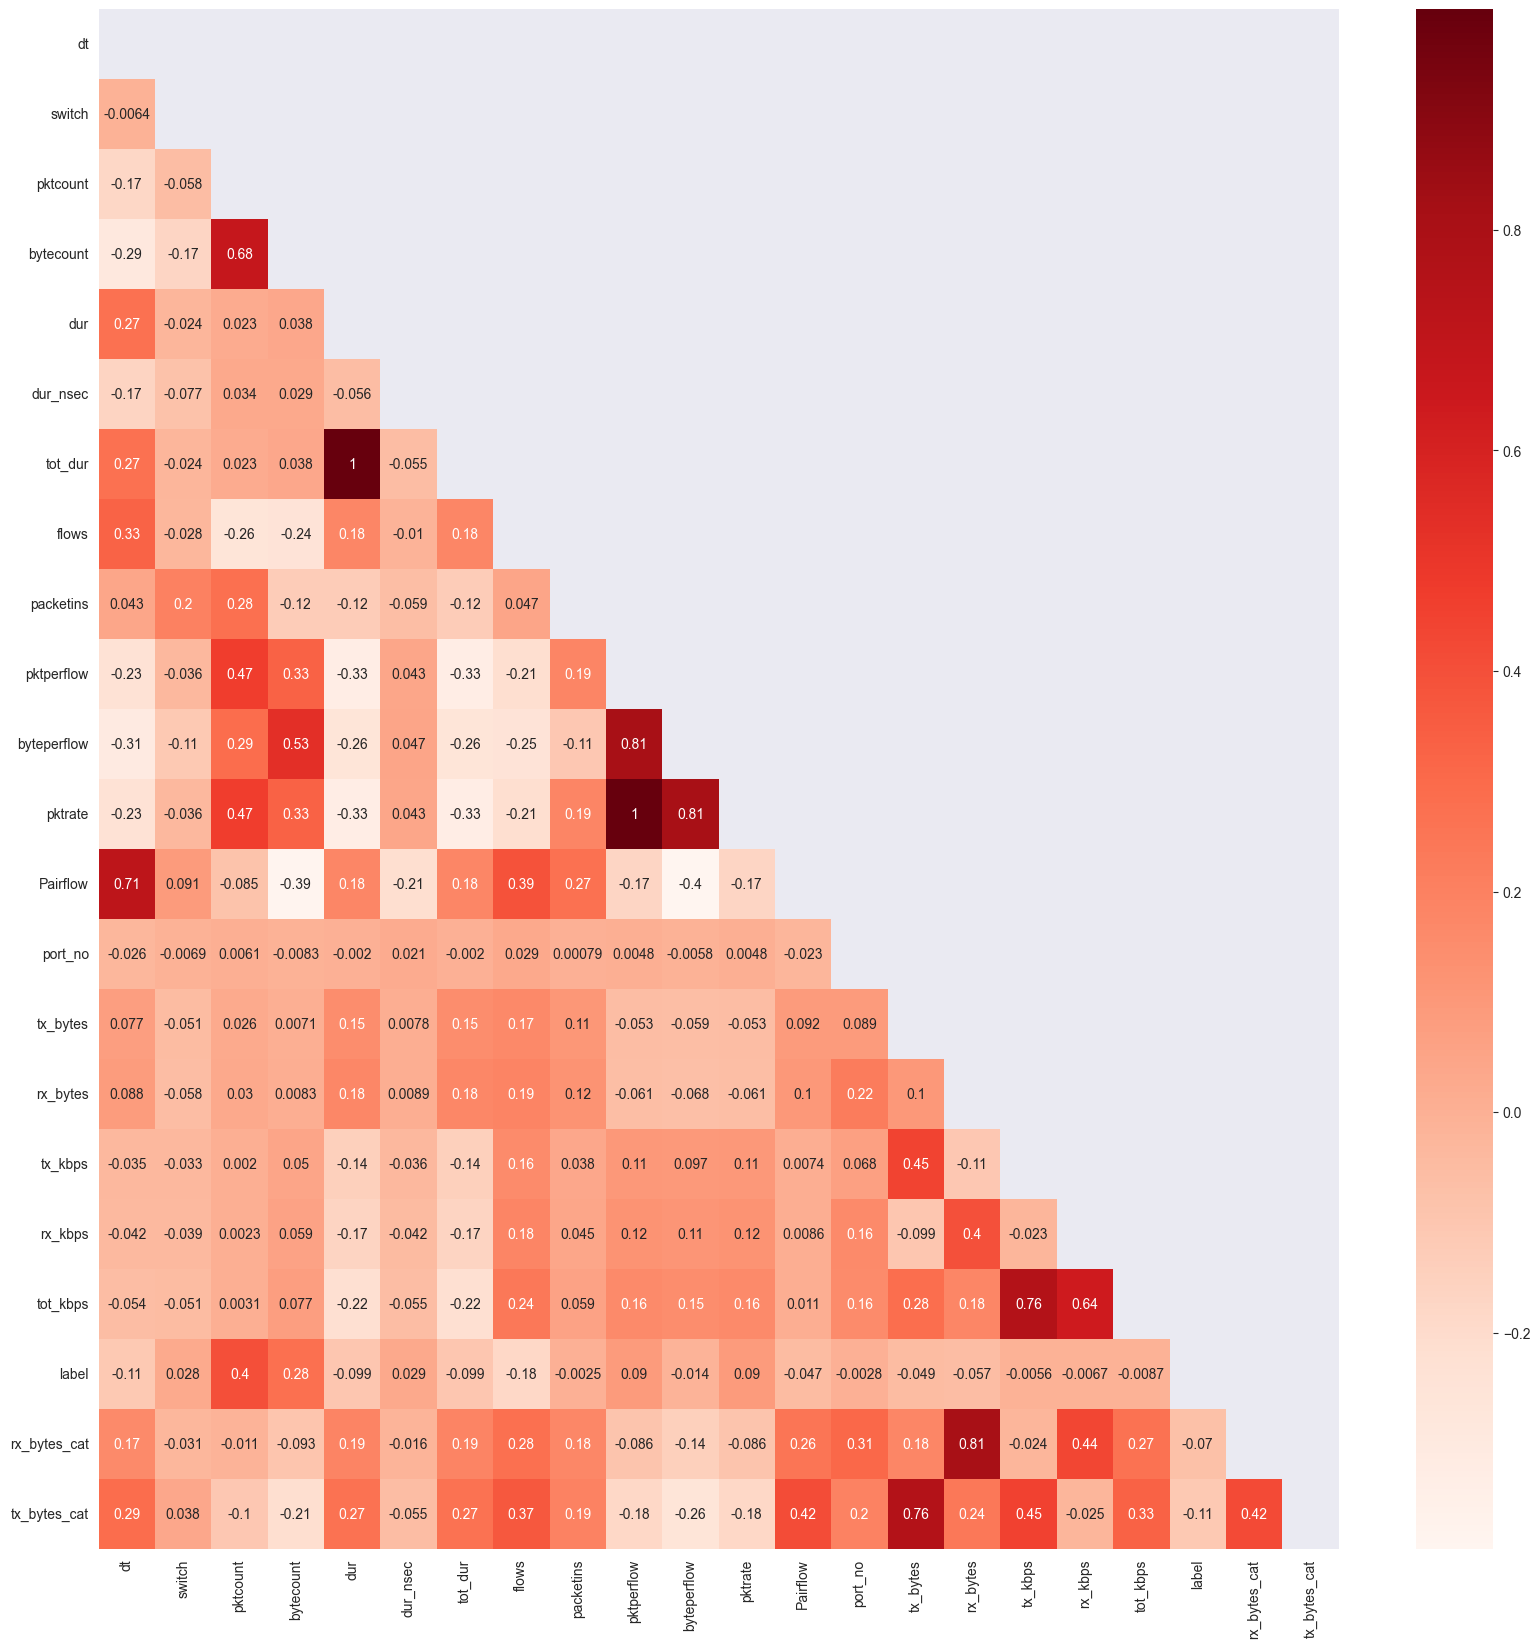

In [15]:
corr = ddos_dp.corr()
mask = np.triu(np.ones_like(corr))
fig, ax = plt.subplots(1,1,figsize=(20,20))
sns.heatmap(corr, mask=mask, annot=True, cmap='Reds', ax=ax)
plt.show()

In [16]:
ddos_dp['Protocol'].value_counts()

ICMP    41321
UDP     33082
TCP     29436
Name: Protocol, dtype: int64

In [17]:
ddos_dp['Protocol'] = ddos_dp['Protocol'].astype('category').replace({'ICMP': 'ICMP_0', 'UDP': 'UDP_1', 'TCP': 'TCP_2'})

<AxesSubplot: xlabel='bytecount', ylabel='pktcount'>

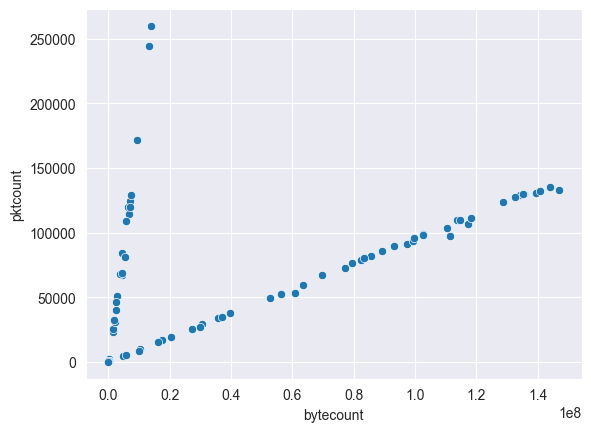

In [18]:
sns.scatterplot(x = 'bytecount', y = 'pktcount', data=ddos_dp.sample(n=100, random_state=42))

<AxesSubplot: xlabel='byteperflow', ylabel='pktrate'>

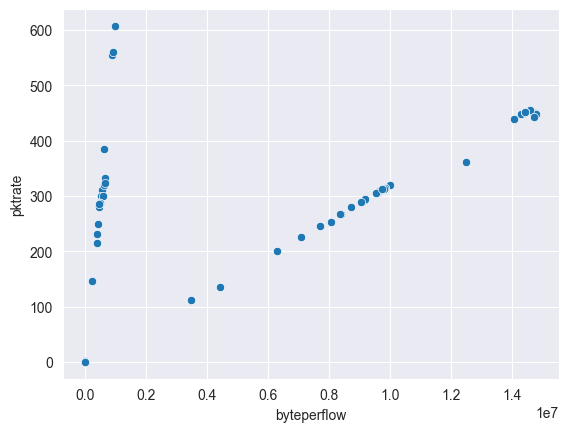

In [19]:
sns.scatterplot(x = 'byteperflow', y = 'pktrate', data=ddos_dp.sample(n=100, random_state=42))

<AxesSubplot: xlabel='pktperflow', ylabel='pktrate'>

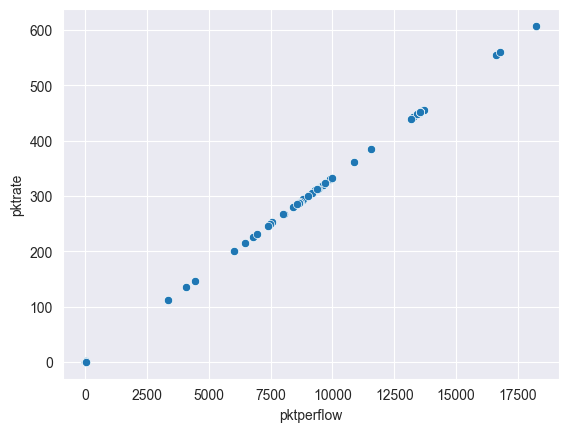

In [20]:
sns.scatterplot(x = 'pktperflow', y = 'pktrate', data=ddos_dp.sample(n=100, random_state=42))

In [21]:
columns_with_null = ddos.isnull().any()
features_with_null = columns_with_null[columns_with_null == True].index

for feature in features_with_null:
    print(feature)
features_with_null

rx_kbps
tot_kbps


Index(['rx_kbps', 'tot_kbps'], dtype='object')

In [22]:
ddos_dp

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label,rx_bytes_cat,tx_bytes_cat
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,UDP_1,3,143928631,3917,0,0.0,0.0,0,2,4
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,451,0,UDP_1,4,3842,3520,0,0.0,0.0,0,2,1
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP_1,1,3795,1242,0,0.0,0.0,0,1,1
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP_1,2,3688,1492,0,0.0,0.0,0,1,1
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP_1,3,3413,3665,0,0.0,0.0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104340,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,10,29,2842,0,0,ICMP_0,1,15209,12720,1,1.0,2.0,0,2,2
104341,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,10,29,2842,0,0,ICMP_0,3,15099,14693,1,1.0,2.0,0,2,2
104342,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,0,ICMP_0,2,3409,3731,0,0.0,0.0,0,2,1
104343,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,0,ICMP_0,1,15209,12720,1,1.0,2.0,0,2,2


In [23]:
# Data preprecessing


class Droper:
    def __init__(self, axis):
        self.axis = axis
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        columns_with_null = X.isnull().any()
        features_with_null = columns_with_null[columns_with_null == True].index
        if self.axis == 0:
            return X.dropna(subset=features_with_null)
        if self.axis == 1:
            return X.drop(columns=features_with_null)

class AugmentData:
    def __init__(self):
        pass
    def separate(seperator, series):
        list = []
        for value in series:
            if value <= separator[0]:
                list.append(1)
            elif value <= separator[1]:
                list.append(2)
            elif value <= separator[2]:
                list.append(3)
            elif value <= separator[3]:
                list.append(4)
            else:
                list.append(5)
        return list
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        cut_line = np.linspace(0, X.shape[0], 6, dtype=int)
        rx_bytes_sorted = X['rx_bytes'].sort_values(ascending=True).to_numpy()
        separator = [rx_bytes_sorted[cut_line[1]], rx_bytes_sorted[cut_line[2]], rx_bytes_sorted[cut_line[3]], rx_bytes_sorted[cut_line[4]]]
        X['rx_bytes_cat'] = separate(separator, X['rx_bytes'])

        cut_line = np.linspace(0, ddos_dp.shape[0], 6, dtype=int)
        tx_bytes_sorted = ddos_dp['tx_bytes'].sort_values(ascending=True).to_numpy()
        separator = [tx_bytes_sorted[cut_line[1]], tx_bytes_sorted[cut_line[2]], tx_bytes_sorted[cut_line[3]], tx_bytes_sorted[cut_line[4]]]
        X['tx_bytes_cat'] = separate(separator, X['tx_bytes'])
        
        le = LabelEncoder()
        X['Protocol'] = le.fit_transform(X['Protocol'])
        
        return X

        

augment = Pipeline([
    ('droper', Droper(axis=0)),
    ('data_augment', AugmentData())
])

X = augment.fit_transform(ddos)
y = X['label']
X = X.drop(columns=['label'])


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [31]:
selector = SelectKBest(k=10).fit(X_train.drop(columns=['src', 'dst', 'dt']), y_train)
cols_idxs = selector.get_support(indices=True)
X_train_best_features = X_train.drop(columns=['src', 'dst', 'dt']).iloc[:,cols_idxs]
X_test_best_features = X_test.drop(columns=['src', 'dst', 'dt']).iloc[:,cols_idxs]

In [32]:
num = Pipeline([
    ('scaler', StandardScaler())
])

cat = Pipeline([
    ('one_hot', OneHotEncoder())
])

categorical = ['Protocol', 'flows', 'rx_bytes_cat', 'tx_bytes_cat']
numeric = ['pktcount', 'bytecount', 'dur', 'tot_dur', 'pktperflow', 'pktrate']

preprocess = ColumnTransformer([
    ('cat', cat, categorical),
    ('num', num, numeric),
], remainder='passthrough')

preprocess.fit(X_train_best_features)

cat_columns = preprocess.named_transformers_['cat'].named_steps['one_hot'].get_feature_names_out(categorical)
columns = np.append(cat_columns, numeric)

X_train_ready = pd.DataFrame(preprocess.transform(X_train_best_features).toarray(), columns=columns)
X_test_ready = pd.DataFrame(preprocess.transform(X_test_best_features).toarray(), columns=columns)
X_test_ready

,Protocol_0,Protocol_1,Protocol_2,flows_2,flows_3,flows_4,flows_5,flows_6,flows_7,flows_8,flows_9,flows_10,flows_11,flows_12,flows_13,flows_14,flows_15,flows_17,rx_bytes_cat_1,rx_bytes_cat_2,rx_bytes_cat_3,rx_bytes_cat_4,rx_bytes_cat_5,tx_bytes_cat_1,tx_bytes_cat_2,tx_bytes_cat_3,tx_bytes_cat_4,tx_bytes_cat_5,pktcount,bytecount,dur,tot_dur,pktperflow,pktrate
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.285280,-0.647371,-0.397547,-0.395558,1.394922,1.395757
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.092569,1.550855,0.310215,0.308969,0.277324,0.276126
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.002123,-0.778583,0.775014,0.773957,-0.857919,-0.855720
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.008507,-0.779250,-0.432759,-0.434307,-0.857919,-0.855720
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.376444,-0.631936,0.415851,0.418171,0.014959,0.015557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20763,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.370565,-0.682337,-0.369378,-0.367377,0.473589,0.475624
20764,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.038926,0.388120,-0.475014,-0.476579,0.390658,0.390124
20765,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.993835,-0.777717,2.317302,2.320395,-0.858055,-0.859791
20766,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.910728,-0.666854,-1.063055,-1.064831,-0.861991,-0.859791


# Try different Logistic Model:

In [27]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_ready, y_train)

LogisticRegression(max_iter=1000)

In [28]:
y_pred = log_reg.predict(X_test_ready)
y_score = log_reg.predict_proba(X_test_ready)[:,1]
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7264060092449923

In [29]:
y_score

array([0.49806613, 0.62621542, 0.1322737 , ..., 0.06334275, 0.37924516,
       0.26520867])

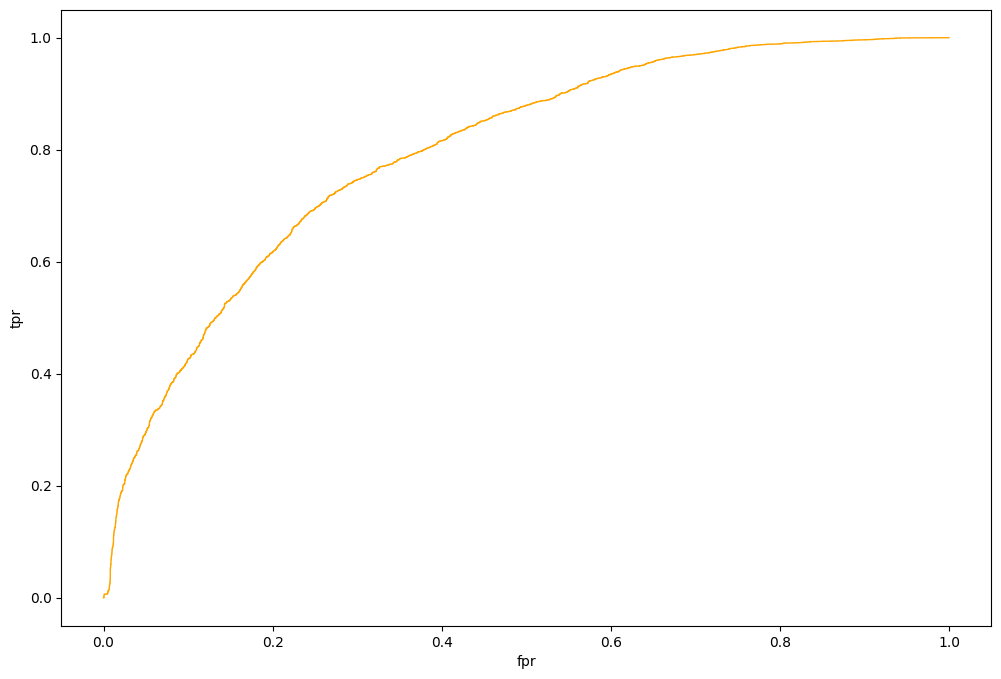

The auc is 0.796


In [30]:
fpr, tpr, threshold = roc_curve(y_test, y_score)
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(fpr, tpr, c='orange', lw=1)
ax.set_ylabel("tpr")
ax.set_xlabel("fpr")
plt.show()
print("The auc is %.3f" % auc(fpr, tpr)) 

In [31]:
from sklearn.model_selection import KFold, cross_val_score
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

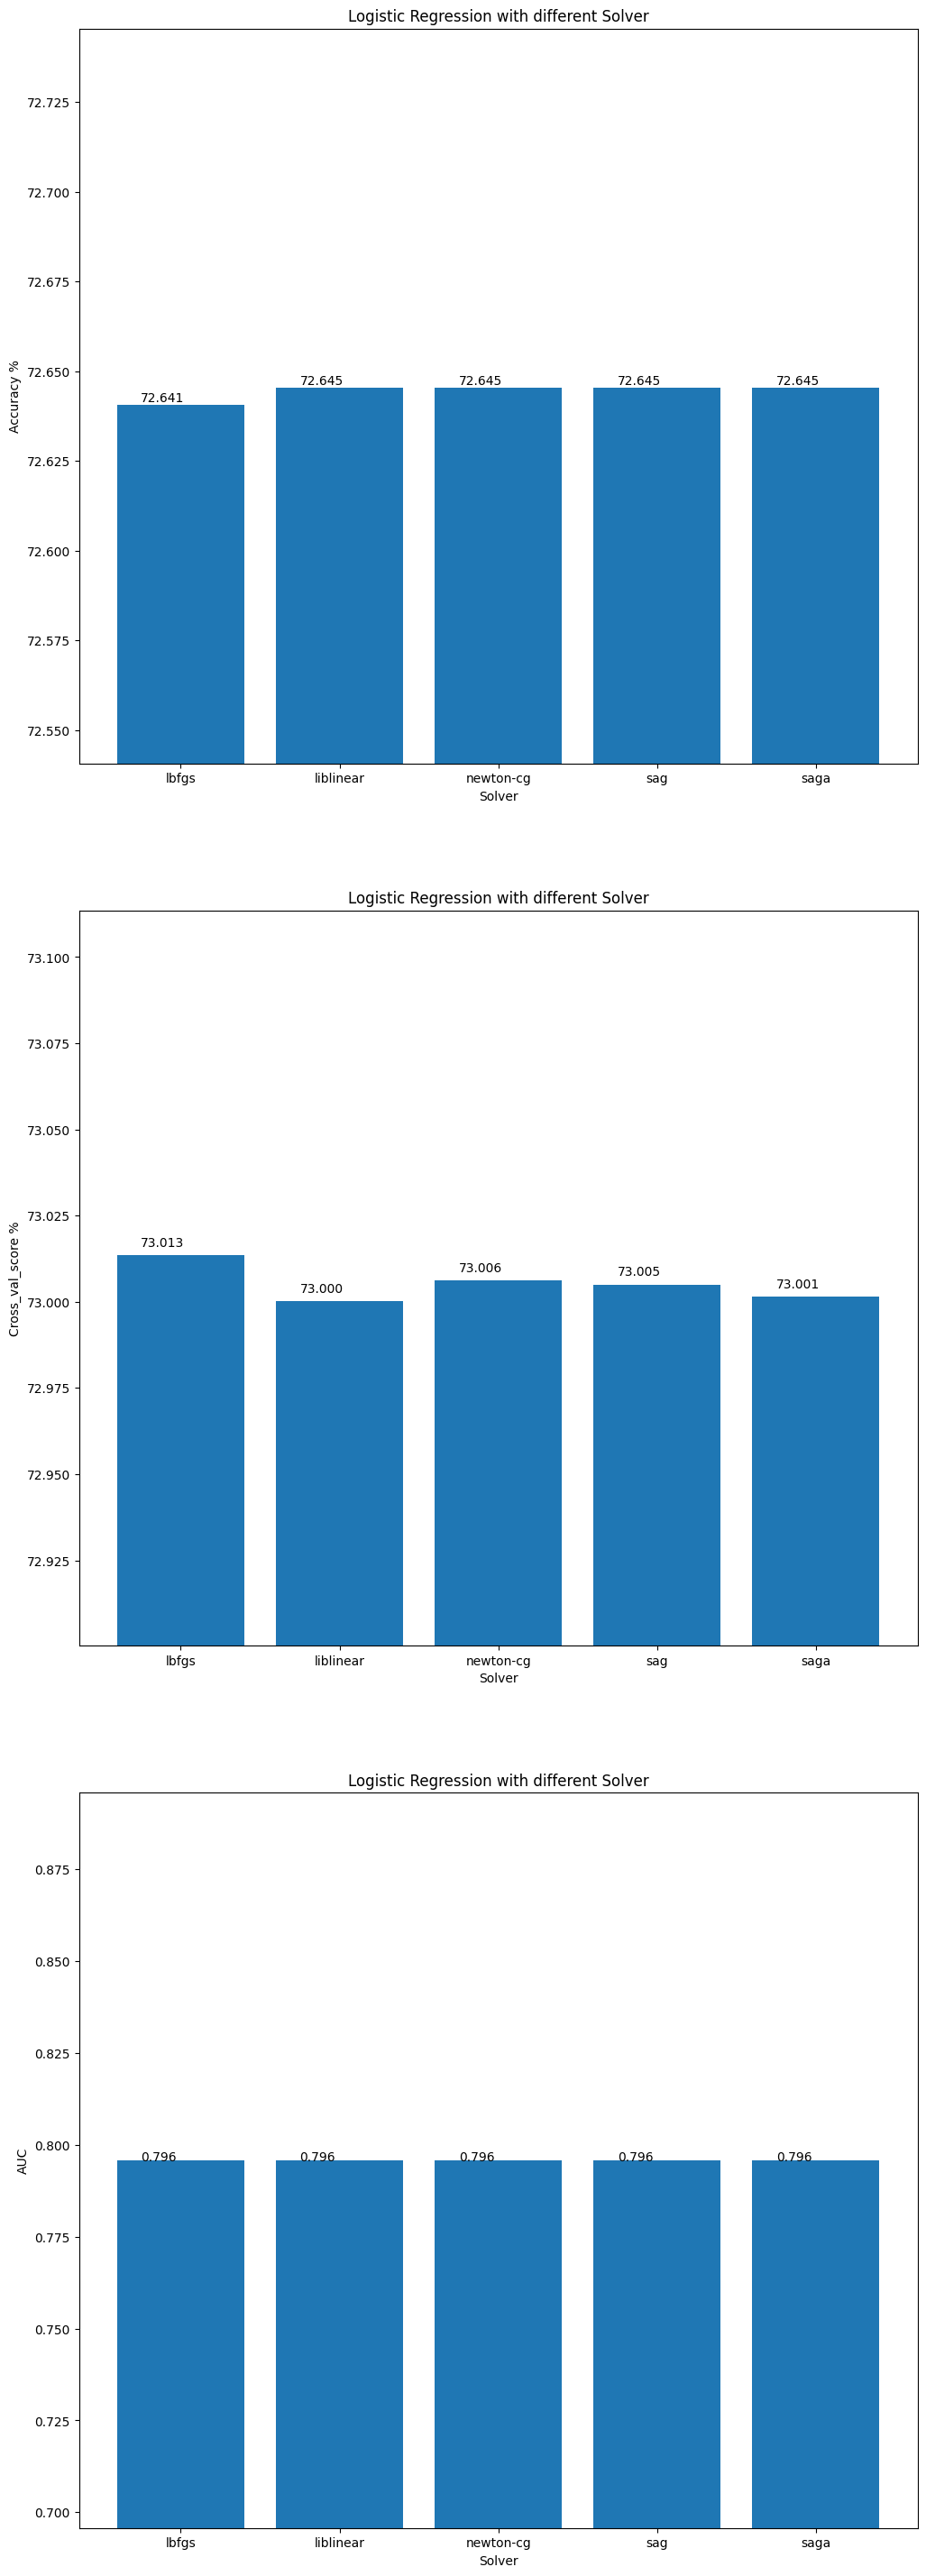

In [31]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
accuracy_log_reg_solver = []
cross_val_score_log_reg_solver = []
auc_log_reg_solver = []

for solver in solvers:
    log_reg = LogisticRegression(max_iter=1000, solver=solver)
    cross_val_score_log_reg_solver.append(cross_val_score(log_reg, X_train_ready, y_train, cv=kfold).mean()*100)
    log_reg.fit(X_train_ready, y_train)
    y_pred = log_reg.predict(X_test_ready)
    y_score = log_reg.predict_proba(X_test_ready)[:,1]
    accuracy_log_reg_solver.append(accuracy_score(y_test, y_pred)*100)
    auc_log_reg_solver.append(auc(roc_curve(y_test, y_score)[0:2][0], roc_curve(y_test, y_score)[0:2][1]))
    

fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(12,36))
    
ax1.bar(solvers, accuracy_log_reg_solver)
ax1.set_xlabel("Solver")
ax1.set_ylim(min(accuracy_log_reg_solver)-0.1, max(accuracy_log_reg_solver)+0.1)
ax1.set_ylabel("Accuracy %")
ax1.set_title("Logistic Regression with different Solver")
for index,data in enumerate(accuracy_log_reg_solver):
    ax1.text(x=index-0.25 , y =data+(max(accuracy_log_reg_solver)-min(accuracy_log_reg_solver))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))
    
ax2.bar(solvers, cross_val_score_log_reg_solver)
ax2.set_xlabel("Solver")
ax2.set_ylim(min(cross_val_score_log_reg_solver)-0.1, max(cross_val_score_log_reg_solver)+0.1)
ax2.set_ylabel("Cross_val_score %")
ax2.set_title("Logistic Regression with different Solver")
for index,data in enumerate(cross_val_score_log_reg_solver):
    ax2.text(x=index-0.25 , y =data+(max(cross_val_score_log_reg_solver)-min(cross_val_score_log_reg_solver))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))


ax3.bar(solvers, auc_log_reg_solver) 
ax3.set_xlabel("Solver")
ax3.set_ylim(min(auc_log_reg_solver)-0.1, max(auc_log_reg_solver)+0.1)
ax3.set_ylabel("AUC")
ax3.set_title("Logistic Regression with different Solver")
for index,data in enumerate(auc_log_reg_solver):
    ax3.text(x=index-0.25 , y =data+(max(auc_log_reg_solver)-min(auc_log_reg_solver))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))

    
plt.show()


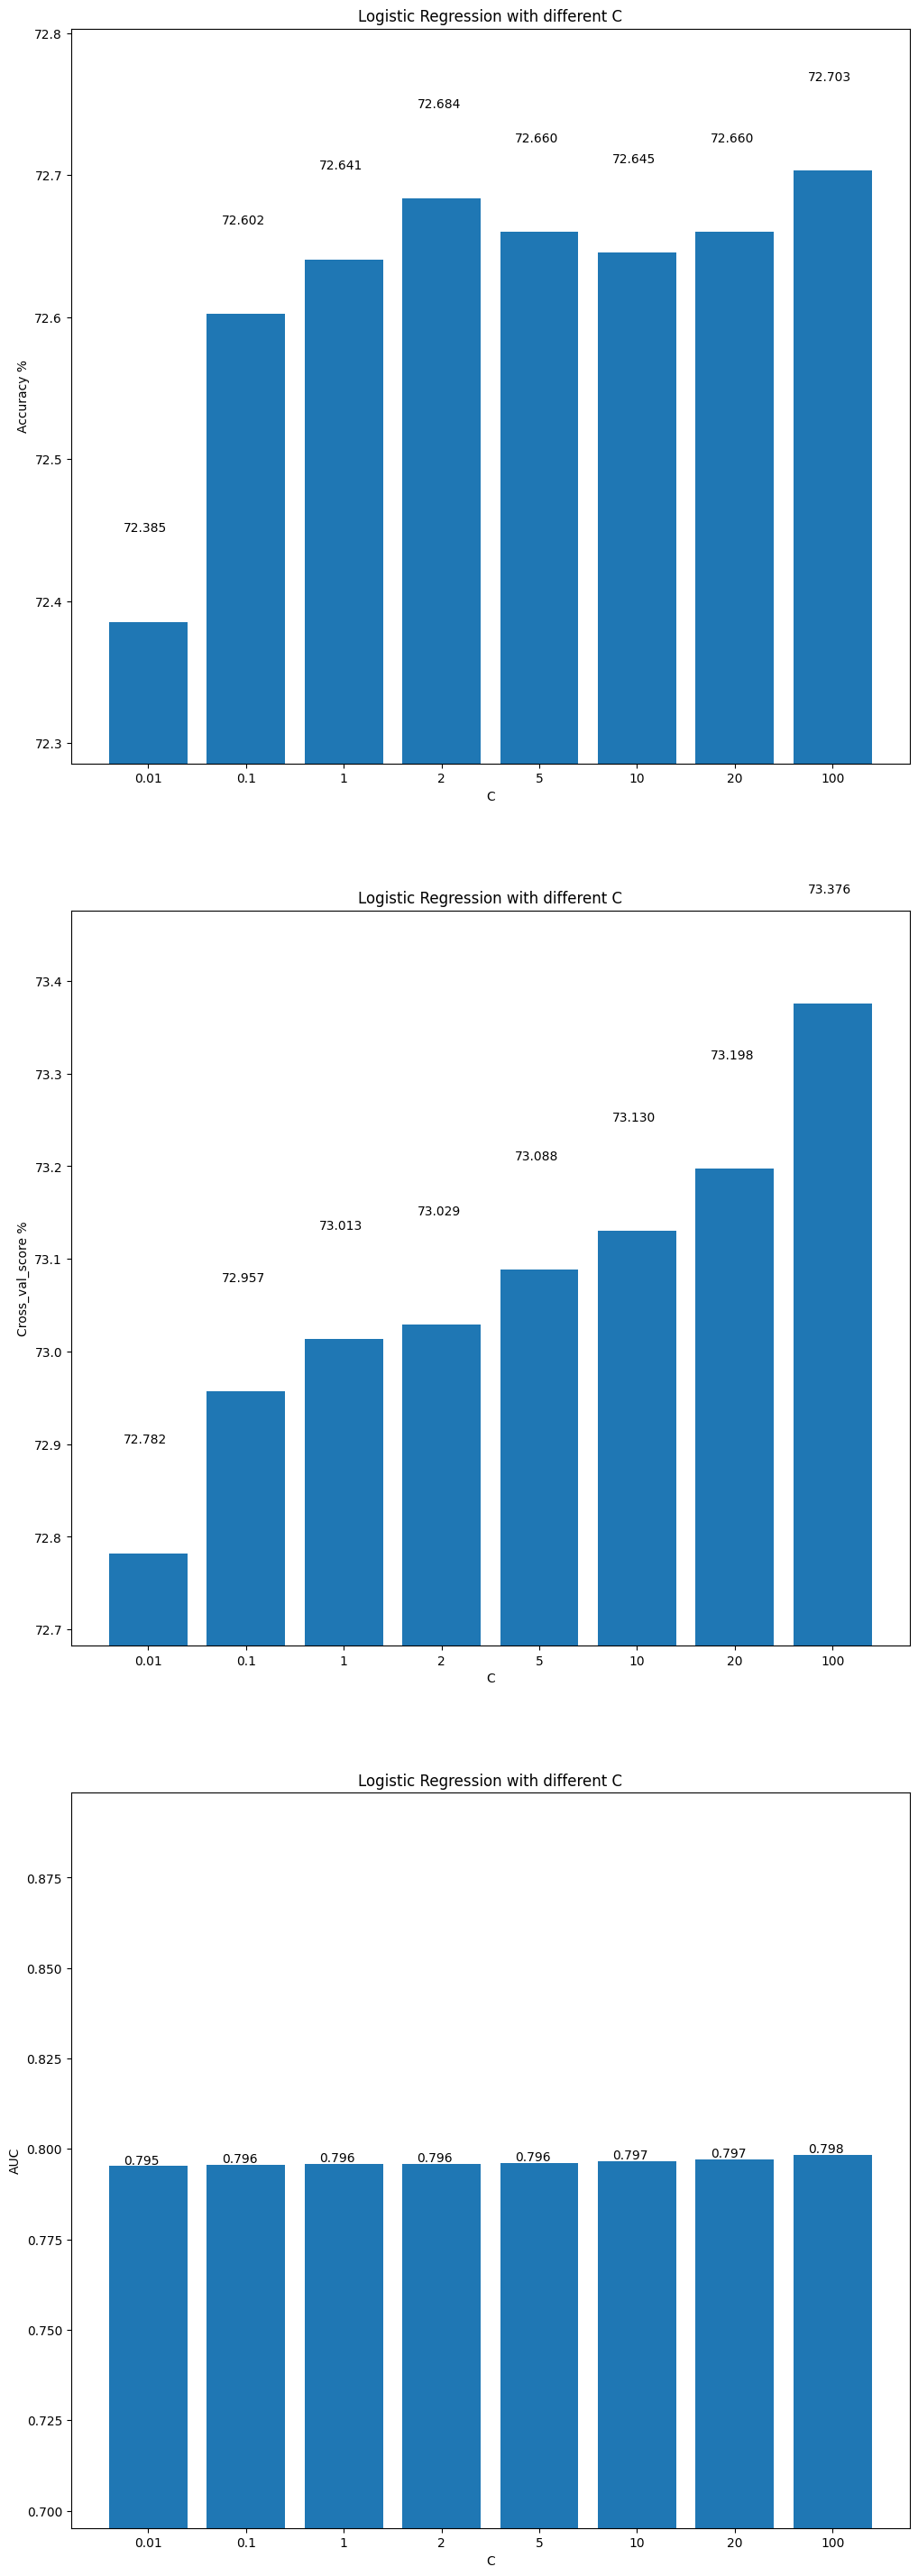

In [57]:
C = [0.01,0.1,1,2,5,10,20,100]
accuracy_log_reg_c = []
cross_val_score_log_reg_c = []
auc_log_reg_c = []

for c in C:
    log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', C=c)
    cross_val_score_log_reg_c.append(cross_val_score(log_reg, X_train_ready, y_train, cv=kfold).mean()*100)
    log_reg.fit(X_train_ready, y_train)
    y_pred = log_reg.predict(X_test_ready)
    y_score = log_reg.predict_proba(X_test_ready)[:,1]
    accuracy_log_reg_c.append(accuracy_score(y_test, y_pred)*100)
    auc_log_reg_c.append(auc(roc_curve(y_test, y_score)[0:2][0], roc_curve(y_test, y_score)[0:2][1]))
    
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(12,36))

ax1.bar([str(c) for c in C], accuracy_log_reg_c)
ax1.set_xlabel("C")
ax1.set_ylim(min(accuracy_log_reg_c)-0.1, max(accuracy_log_reg_c)+0.1)
ax1.set_ylabel("Accuracy %")
ax1.set_title("Logistic Regression with different C")
for index,data in enumerate(accuracy_log_reg_c):
    ax1.text(x=index-0.25 , y=data+(max(accuracy_log_reg_c)-min(accuracy_log_reg_c))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))

ax2.bar([str(c) for c in C], cross_val_score_log_reg_c)
ax2.set_xlabel("C")
ax2.set_ylim(min(cross_val_score_log_reg_c)-0.1, max(cross_val_score_log_reg_c)+0.1)
ax2.set_ylabel("Cross_val_score %")
ax2.set_title("Logistic Regression with different C")
for index,data in enumerate(cross_val_score_log_reg_c):
    ax2.text(x=index-0.25 , y =data+(max(cross_val_score_log_reg_c)-min(cross_val_score_log_reg_c))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))


ax3.bar([str(c) for c in C], auc_log_reg_c) 
ax3.set_xlabel("C")
ax3.set_ylim(min(auc_log_reg_c)-0.1, max(auc_log_reg_c)+0.1)
ax3.set_ylabel("AUC")
ax3.set_title("Logistic Regression with different C")
for index,data in enumerate(auc_log_reg_c):
    ax3.text(x=index-0.25 , y =data+(max(auc_log_reg_c)-min(auc_log_reg_c))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))

    
    
plt.show()

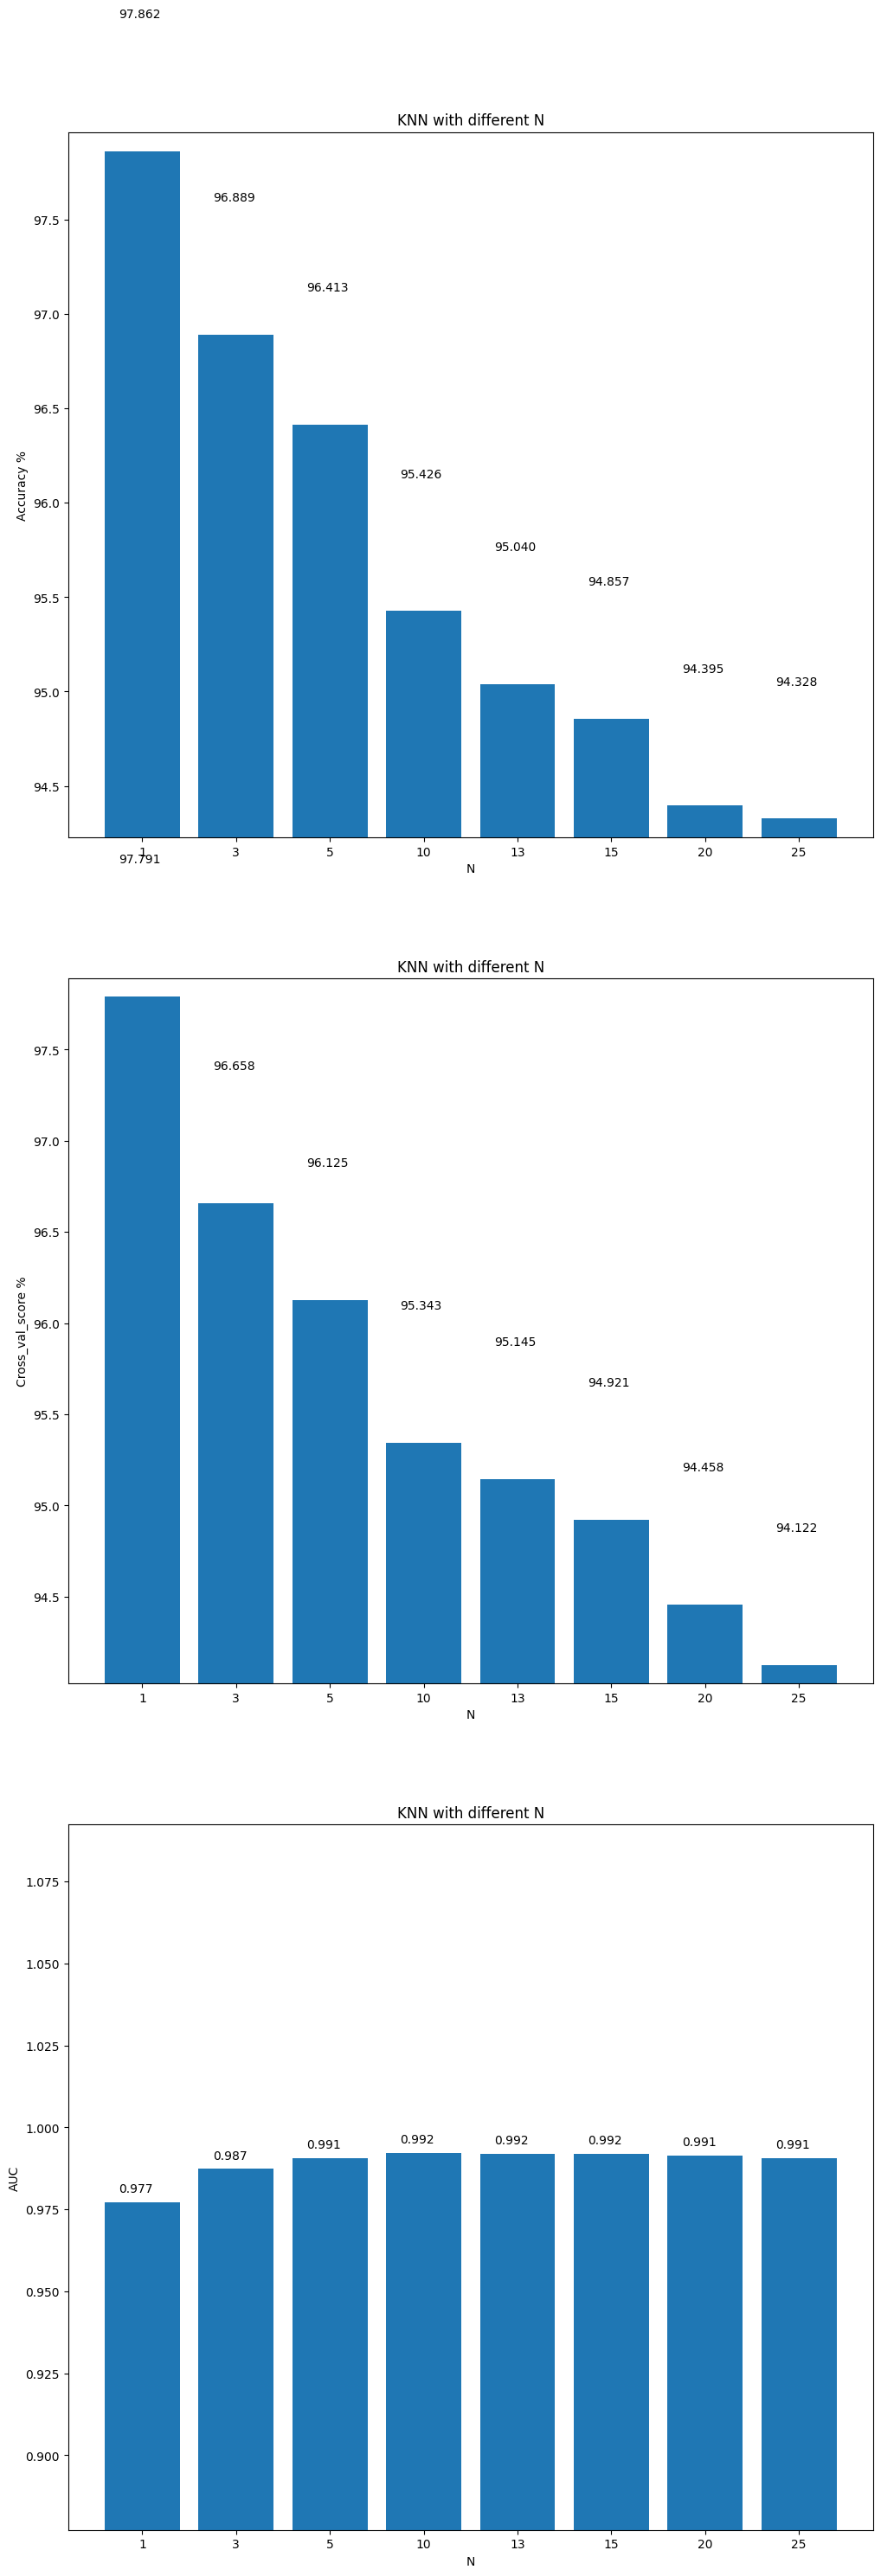

In [32]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = [1,3,5,10,13,15,20,25]
accuracy_knn_neighbors = []
cross_val_score_knn_neighbors = []
auc_knn_neighbors = []

for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors = neighbor)
    cross_val_score_knn_neighbors.append(cross_val_score(knn, X_train_ready, y_train, cv=kfold).mean()*100)
    knn.fit(X_train_ready, y_train)
    y_pred = knn.predict(X_test_ready)
    y_score = knn.predict_proba(X_test_ready)[:,1]
    accuracy_knn_neighbors.append(accuracy_score(y_test, y_pred)*100)
    auc_knn_neighbors.append(auc(roc_curve(y_test, y_score)[0:2][0], roc_curve(y_test, y_score)[0:2][1]))

    
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(12,36))

ax1.bar([str(n) for n in neighbors], accuracy_knn_neighbors)
ax1.set_xlabel("N")
ax1.set_ylim(min(accuracy_knn_neighbors)-0.1, max(accuracy_knn_neighbors)+0.1)
ax1.set_ylabel("Accuracy %")
ax1.set_title("KNN with different N")
for index,data in enumerate(accuracy_knn_neighbors):
    ax1.text(x=index-0.25 , y=data+(max(accuracy_knn_neighbors)-min(accuracy_knn_neighbors))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))

ax2.bar([str(n) for n in neighbors], cross_val_score_knn_neighbors)
ax2.set_xlabel("N")
ax2.set_ylim(min(cross_val_score_knn_neighbors)-0.1, max(cross_val_score_knn_neighbors)+0.1)
ax2.set_ylabel("Cross_val_score %")
ax2.set_title("KNN with different N")
for index,data in enumerate(cross_val_score_knn_neighbors):
    ax2.text(x=index-0.25 , y =data+(max(cross_val_score_knn_neighbors)-min(cross_val_score_knn_neighbors))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))


ax3.bar([str(n) for n in neighbors], auc_knn_neighbors) 
ax3.set_xlabel("N")
ax3.set_ylim(min(auc_knn_neighbors)-0.1, max(auc_knn_neighbors)+0.1)
ax3.set_ylabel("AUC")
ax3.set_title("KNN with different N")
for index,data in enumerate(auc_knn_neighbors):
    ax3.text(x=index-0.25 , y =data+(max(auc_knn_neighbors)-min(auc_knn_neighbors))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))

    
    
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(12,36))

accuracy_knn_neighbors = [acc*100.0 for acc in accuracy_knn_neighbors]

ax1.bar([str(n) for n in neighbors], accuracy_knn_neighbors)
ax1.set_xlabel("N")
ax1.set_ylim(min(accuracy_knn_neighbors)-0.1, max(accuracy_knn_neighbors)+0.1)
ax1.set_ylabel("Accuracy %")
ax1.set_title("KNN with different N")
for index,data in enumerate(accuracy_knn_neighbors):
    ax1.text(x=index-0.25 , y=data+(max(accuracy_knn_neighbors)-min(accuracy_knn_neighbors))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))

ax2.bar([str(n) for n in neighbors], cross_val_score_knn_neighbors)
ax2.set_xlabel("N")
ax2.set_ylim(min(cross_val_score_knn_neighbors)-0.1, max(cross_val_score_knn_neighbors)+0.1)
ax2.set_ylabel("Cross_val_score %")
ax2.set_title("KNN with different N")
for index,data in enumerate(cross_val_score_knn_neighbors):
    ax2.text(x=index-0.25 , y =data+(max(cross_val_score_knn_neighbors)-min(cross_val_score_knn_neighbors))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))


ax3.bar([str(n) for n in neighbors], auc_knn_neighbors) 
ax3.set_xlabel("N")
ax3.set_ylim(min(auc_knn_neighbors)-0.1, max(auc_knn_neighbors)+0.1)
ax3.set_ylabel("AUC")
ax3.set_title("KNN with different N")
for index,data in enumerate(auc_knn_neighbors):
    ax3.text(x=index-0.25 , y =data+(max(auc_knn_neighbors)-min(auc_knn_neighbors))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))

    
    
plt.show()

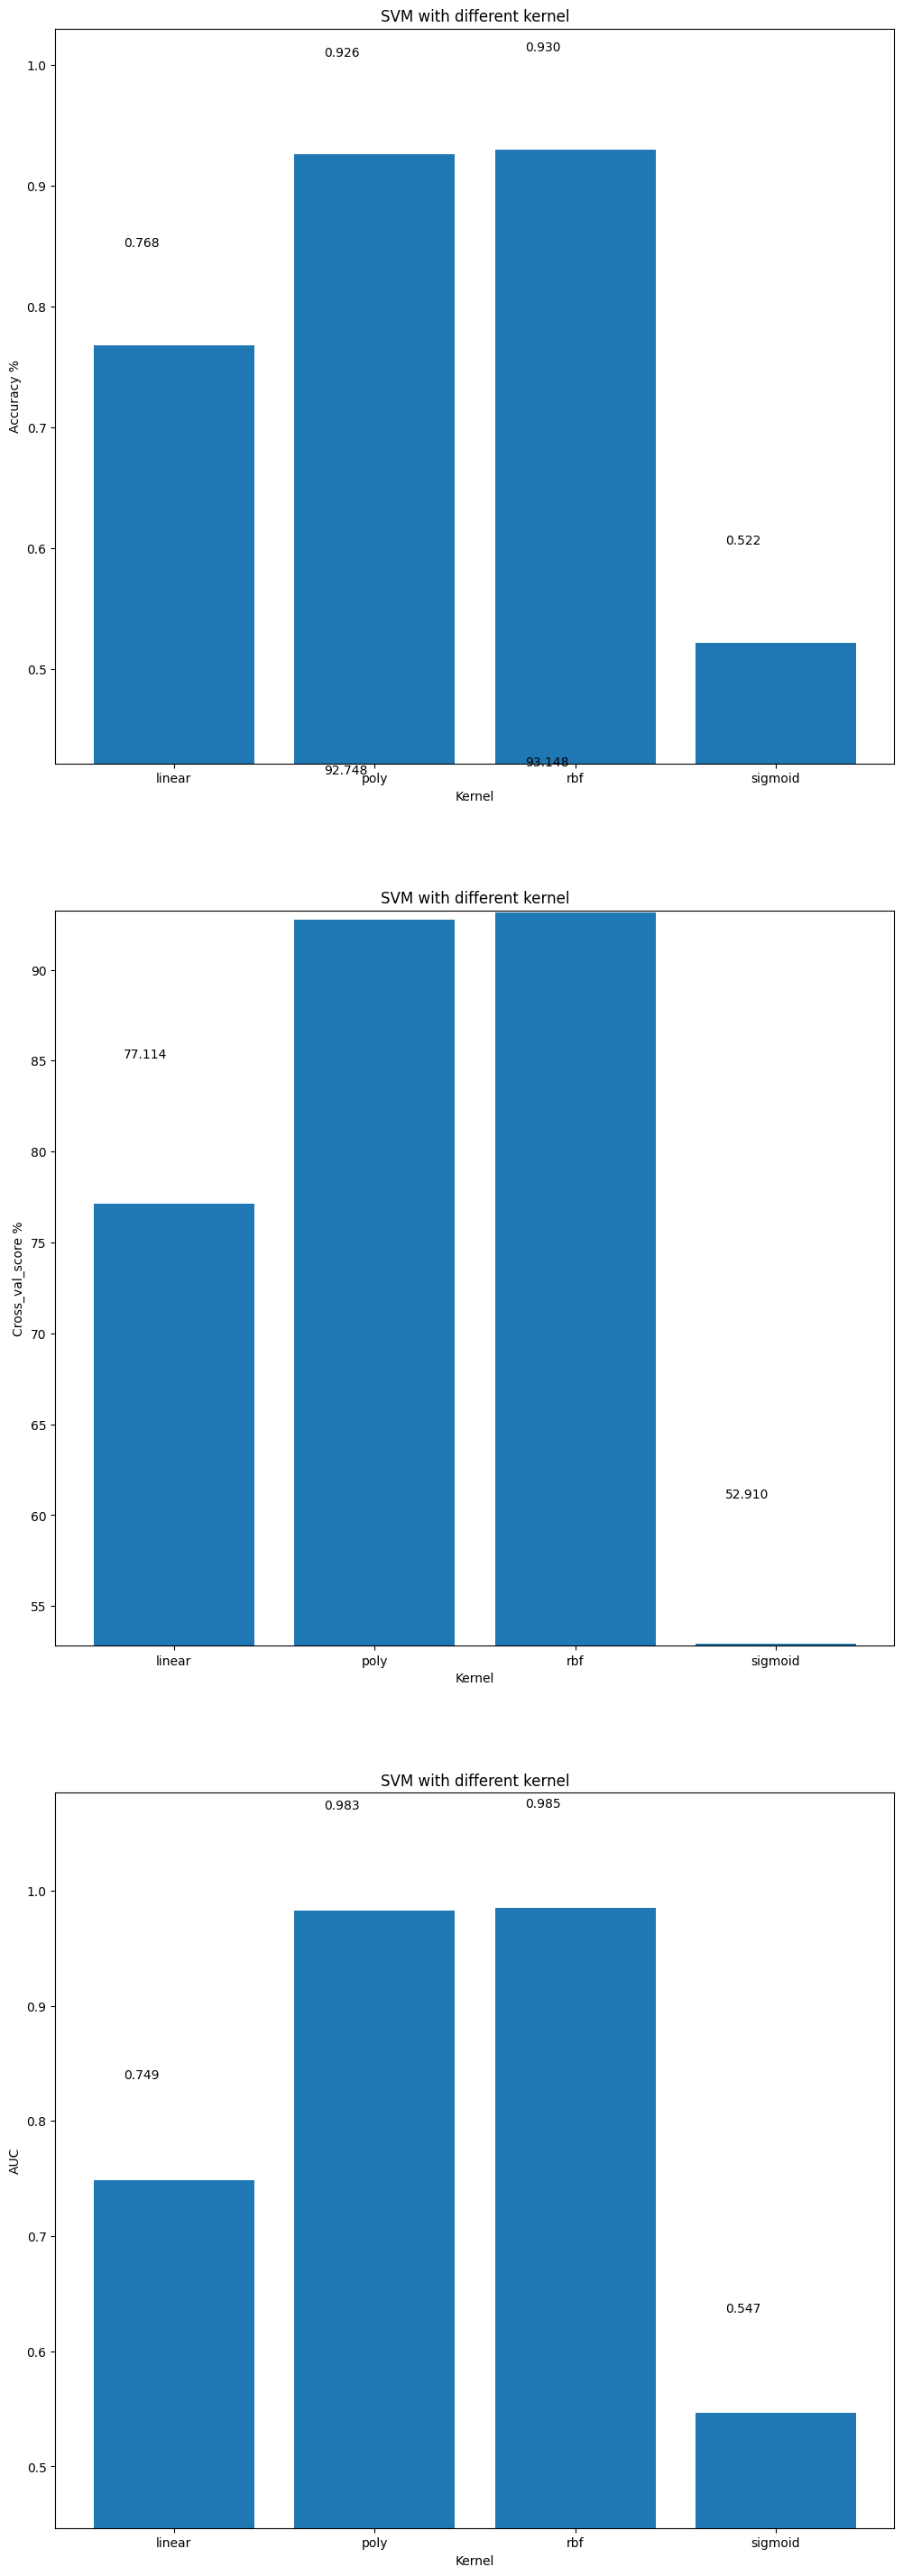

In [33]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

from sklearn.svm import SVC
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

accuracy_svm_kernels = []
cross_val_score_svm_kernels = []
auc_svm_kernels = []

for kernel in kernels:
    svm = SVC(kernel=kernel, probability=True)
    cross_val_score_svm_kernels.append(cross_val_score(svm, X_train_ready, y_train, cv=kfold).mean()*100)
    svm.fit(X_train_ready, y_train)
    y_pred = svm.predict(X_test_ready)
    y_score = svm.predict_proba(X_test_ready)[:,1]
    accuracy_svm_kernels.append(accuracy_score(y_test, y_pred))
    auc_svm_kernels.append(auc(roc_curve(y_test, y_score)[0:2][0], roc_curve(y_test, y_score)[0:2][1]))
    
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(12,36))



ax1.bar(kernels, accuracy_svm_kernels)
ax1.set_xlabel("Kernel")
ax1.set_ylim(min(accuracy_svm_kernels)-0.1, max(accuracy_svm_kernels)+0.1)
ax1.set_ylabel("Accuracy %")
ax1.set_title("SVM with different kernel")
for index,data in enumerate(accuracy_svm_kernels):
    ax1.text(x=index-0.25 , y=data+(max(accuracy_svm_kernels)-min(accuracy_svm_kernels))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))



ax2.bar(kernels, cross_val_score_svm_kernels)
ax2.set_xlabel("Kernel")
ax2.set_ylim(min(cross_val_score_svm_kernels)-0.1, max(cross_val_score_svm_kernels)+0.1)
ax2.set_ylabel("Cross_val_score %")
ax2.set_title("SVM with different kernel")
for index,data in enumerate(cross_val_score_svm_kernels):
    ax2.text(x=index-0.25 , y =data+(max(cross_val_score_svm_kernels)-min(cross_val_score_svm_kernels))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))


ax3.bar(kernels, auc_svm_kernels) 
ax3.set_xlabel("Kernel")
ax3.set_ylim(min(auc_svm_kernels)-0.1, max(auc_svm_kernels)+0.1)
ax3.set_ylabel("AUC")
ax3.set_title("SVM with different kernel")
for index,data in enumerate(auc_svm_kernels):
    ax3.text(x=index-0.25 , y =data+(max(auc_svm_kernels)-min(auc_svm_kernels))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))

plt.show()

In [ ]:
import time
from sklearn.metrics import classification_report

def SupportVectorMachine():
    start_time = time.time()
    accuracy_list = []
    result_svm = []
    kernels = ['linear','poly', 'rbf','sigmoid']
    
    for kernel in kernels:
        
        SVM = svm.SVC(kernel=kernel).fit(self.X_train, y_train) 
        predicted_svm = SVM.predict (self.X_test)
        accuracy_svm = accuracy_score(self.y_test, predicted_svm)
        result_svm.append({"kernel" : kernel, "accuracy": f"{round(accuracy_svm*100,2)}%"})
        print(kernel, ": Accuracy: %.2f%%" % round ((accuracy_svm * 100.0) ,2))
        print('############################################################################')
        accuracy_list.append(accuracy_svm)
    make_graph(labels = kernels, values = accuracy_list, x_label= 'Kernels', y_label = 'Accuracy' , title = 'Support Vector Machine')
    kernel_name = kernels[accuracy_list.index(max(accuracy_list))]
    SVM = svm.SVC(kernel=kernel_name).fit(self.X_train, self.y_train)
    predicted_svm = SVM.predict(self.X_test)
    accuracy_svm = accuracy_score(self.y_test, predicted_svm)
    models['SVM'] = accuracy_svm
    print(f"Accuracy of SVM model {round(accuracy_svm, 2)*100}%", "\n" )
    print('#####################################################kernel_name############')
    print('Best kernel is', kernel_name)
    print('############################################################################')
    print(classification_report(predicted_svm, self.y_test))
    print('############################################################################')
    print("--- %s seconds ---" % (time.time() - start_time))




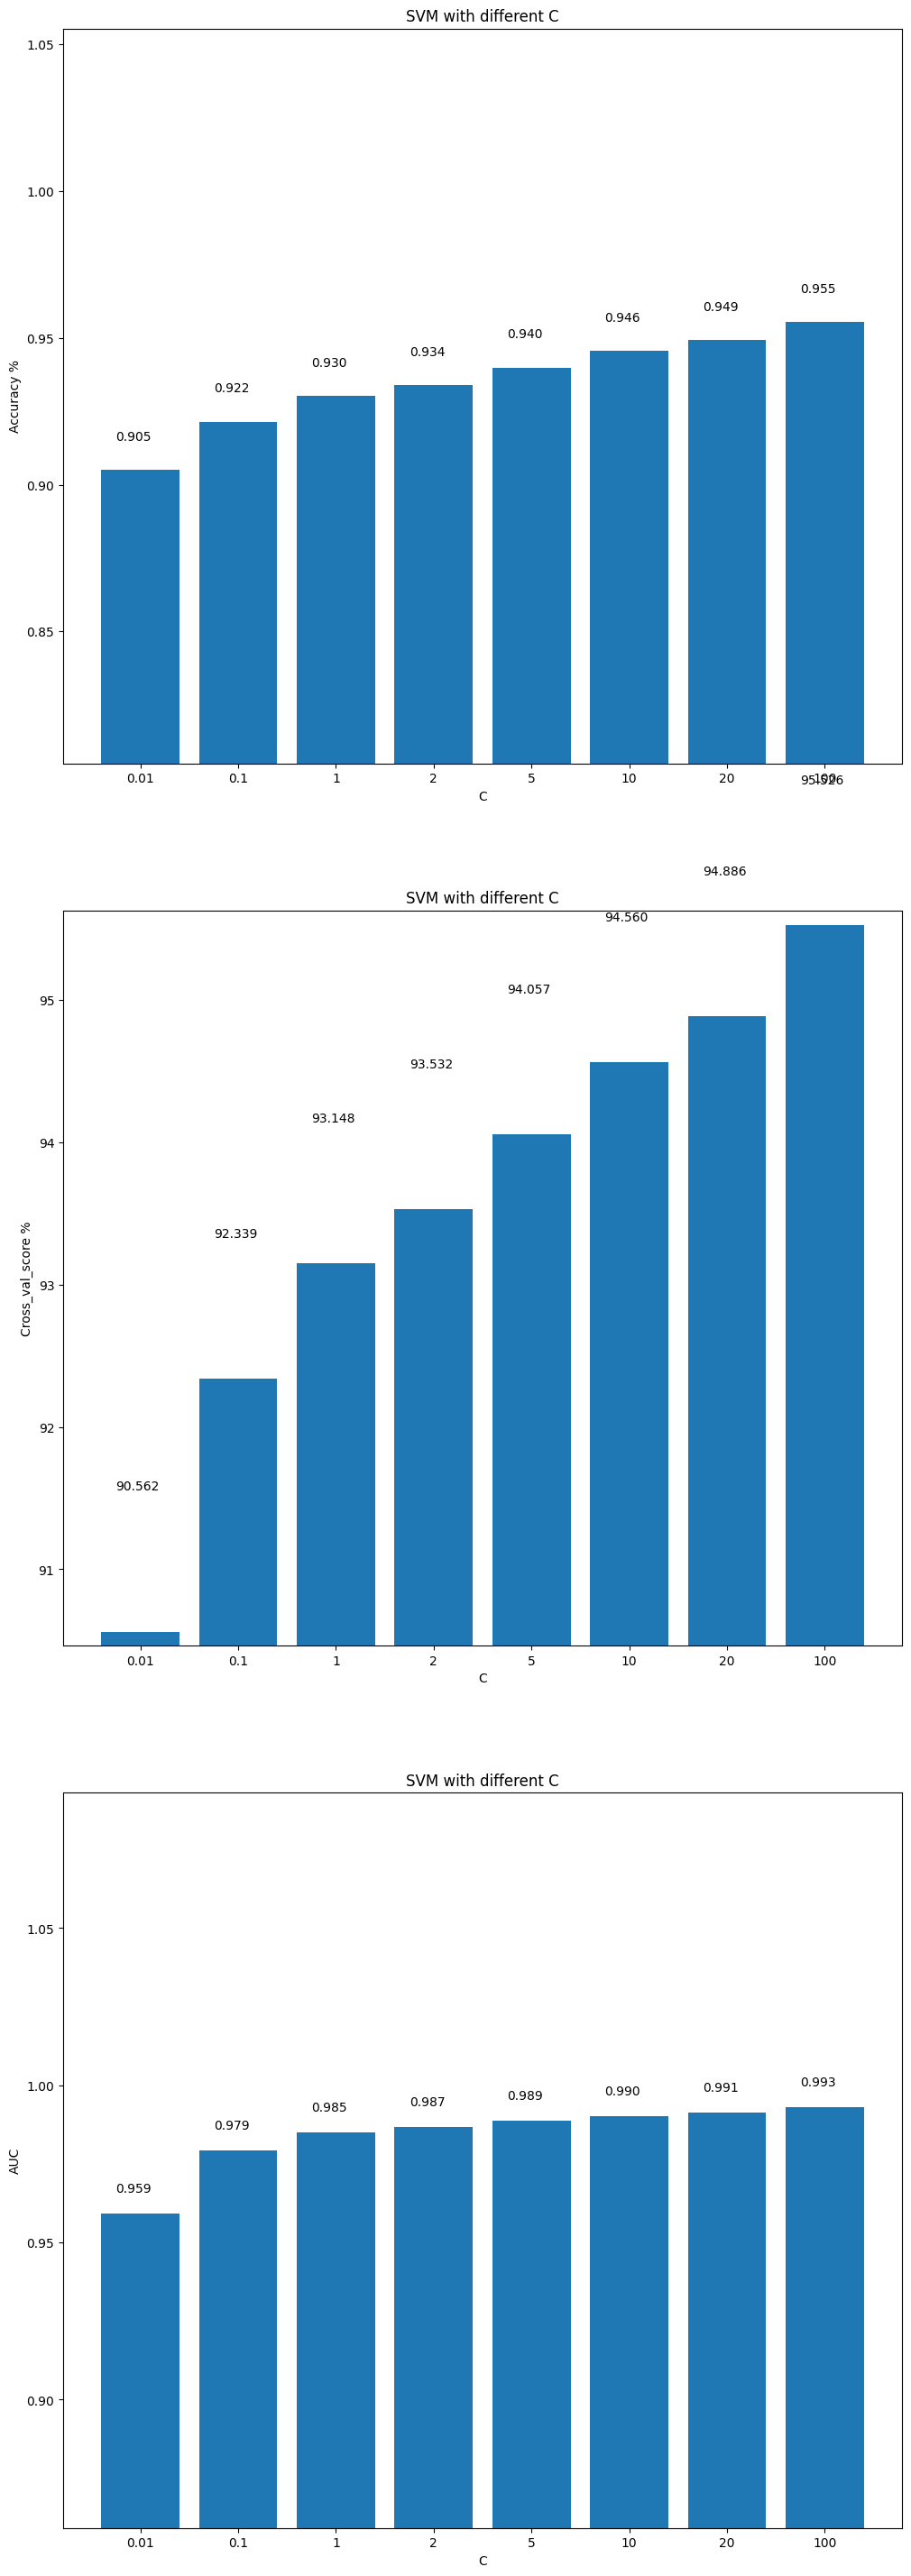

In [35]:
from sklearn.svm import SVC
C = [0.01,0.1,1,2,5,10,20,100]
accuracy_svm_c = []
cross_val_score_svm_c = []
auc_svm_c = []
for c in C:
    
    svm = SVC(C=c, kernel='rbf', probability = True)
    cross_val_score_svm_c.append(cross_val_score(svm, X_train_ready, y_train, cv=kfold).mean()*100)
    
    svm.fit(X_train_ready, y_train)
    y_score = svm.predict_proba(X_test_ready)[:,1]
    y_pred = svm.predict(X_test_ready)
    accuracy_svm_c.append(accuracy_score(y_test, y_pred))
    auc_svm_c.append(auc(roc_curve(y_test, y_score)[0:2][0], roc_curve(y_test, y_score)[0:2][1]))

fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(12,36))

ax1.bar([str(c) for c in C], accuracy_svm_c)
ax1.set_xlabel("C")
ax1.set_ylim(min(accuracy_svm_c)-0.1, max(accuracy_svm_c)+0.1)
ax1.set_ylabel("Accuracy %")
ax1.set_title("SVM with different C")
for index,data in enumerate(accuracy_svm_c):
    ax1.text(x=index-0.25 , y=data+(max(accuracy_svm_c)-min(accuracy_svm_c))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))

ax2.bar([str(c) for c in C], cross_val_score_svm_c)
ax2.set_xlabel("C")
ax2.set_ylim(min(cross_val_score_svm_c)-0.1, max(cross_val_score_svm_c)+0.1)
ax2.set_ylabel("Cross_val_score %")
ax2.set_title("SVM with different C")
for index,data in enumerate(cross_val_score_svm_c):
    ax2.text(x=index-0.25 , y =data+(max(cross_val_score_svm_c)-min(cross_val_score_svm_c))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))


ax3.bar([str(c) for c in C], auc_svm_c) 
ax3.set_xlabel("C")
ax3.set_ylim(min(auc_svm_c)-0.1, max(auc_svm_c)+0.1)
ax3.set_ylabel("AUC")
ax3.set_title("SVM with different C")
for index,data in enumerate(auc_svm_c):
    ax3.text(x=index-0.25 , y =data+(max(auc_svm_c)-min(auc_svm_c))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))



plt.show()

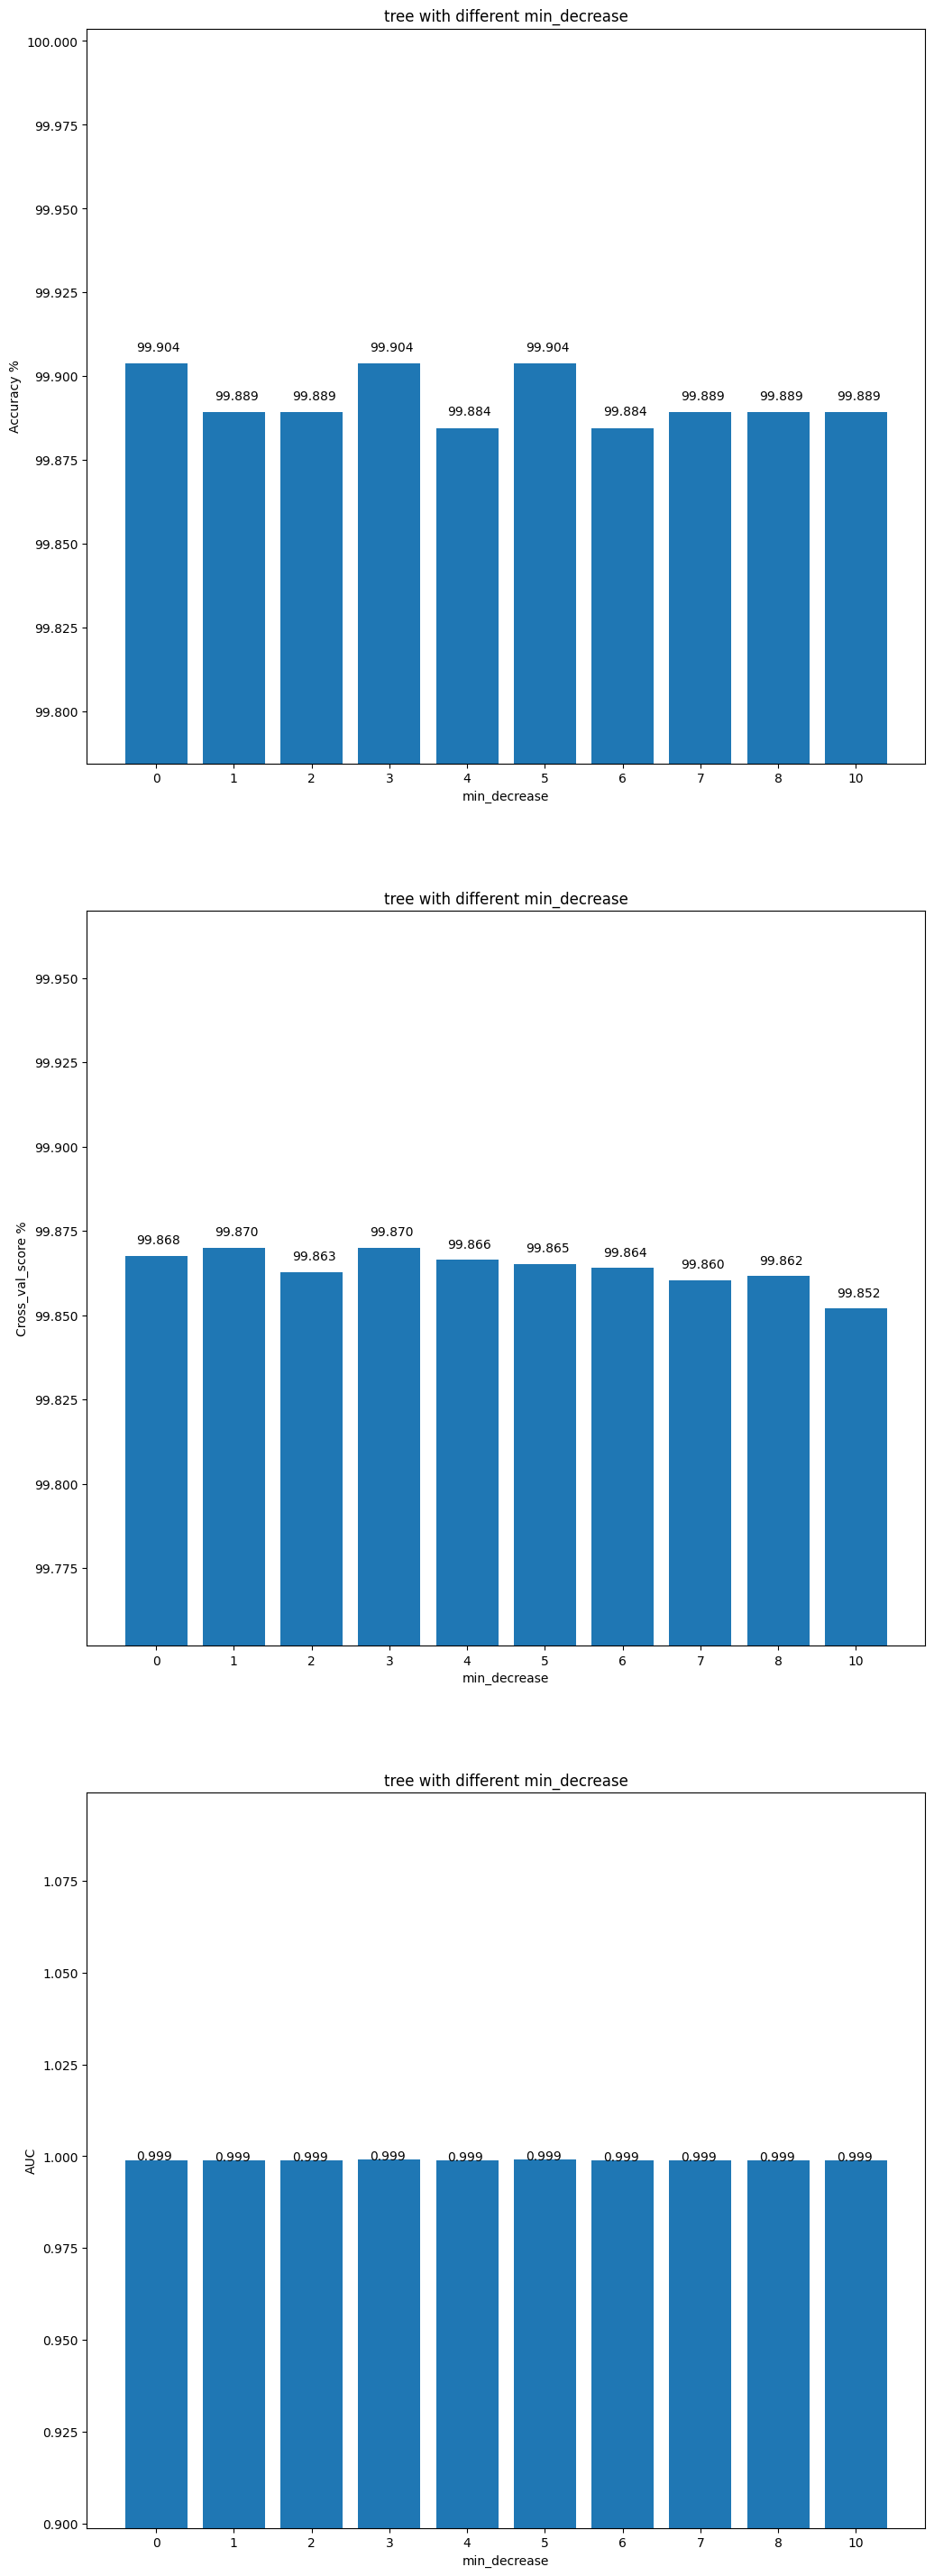

In [37]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

from sklearn.tree import DecisionTreeClassifier, plot_tree

min_decrease = np.linspace(0,10,10, dtype=int)
accuracy_tree_imp = []
cross_val_score_tree_imp = []
auc_tree_imp = []
for n in min_decrease:
    decision_tree = DecisionTreeClassifier()
    cross_val_score_tree_imp.append(cross_val_score(decision_tree, X_train_ready, y_train, cv=kfold).mean()*100)
    
    decision_tree.fit(X_train_ready, y_train)
    y_score = decision_tree.predict_proba(X_test_ready)[:,1]
    y_pred = decision_tree.predict(X_test_ready)
    accuracy_tree_imp.append(accuracy_score(y_test, y_pred)*100)
    auc_tree_imp.append(auc(roc_curve(y_test, y_score)[0:2][0], roc_curve(y_test, y_score)[0:2][1]))
    
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(12,36))

ax1.bar([str(n) for n in min_decrease], accuracy_tree_imp)
ax1.set_xlabel("min_decrease")
ax1.set_ylim(min(accuracy_tree_imp)-0.1, max(accuracy_tree_imp)+0.1)
ax1.set_ylabel("Accuracy %")
ax1.set_title("tree with different min_decrease")
for index,data in enumerate(accuracy_tree_imp):
    ax1.text(x=index-0.25 , y=data+(max(accuracy_tree_imp)-min(accuracy_tree_imp))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))

ax2.bar([str(n) for n in min_decrease], cross_val_score_tree_imp)
ax2.set_xlabel("min_decrease")
ax2.set_ylim(min(cross_val_score_tree_imp)-0.1, max(cross_val_score_tree_imp)+0.1)
ax2.set_ylabel("Cross_val_score %")
ax2.set_title("tree with different min_decrease")
for index,data in enumerate(cross_val_score_tree_imp):
    ax2.text(x=index-0.25 , y =data+(max(cross_val_score_tree_imp)-min(cross_val_score_tree_imp))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))


ax3.bar([str(n) for n in min_decrease], auc_tree_imp) 
ax3.set_xlabel("min_decrease")
ax3.set_ylim(min(auc_tree_imp)-0.1, max(auc_tree_imp)+0.1)
ax3.set_ylabel("AUC")
ax3.set_title("tree with different min_decrease")
for index,data in enumerate(auc_tree_imp):
    ax3.text(x=index-0.25 , y =data+(max(auc_tree_imp)-min(auc_tree_imp))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))



plt.show()

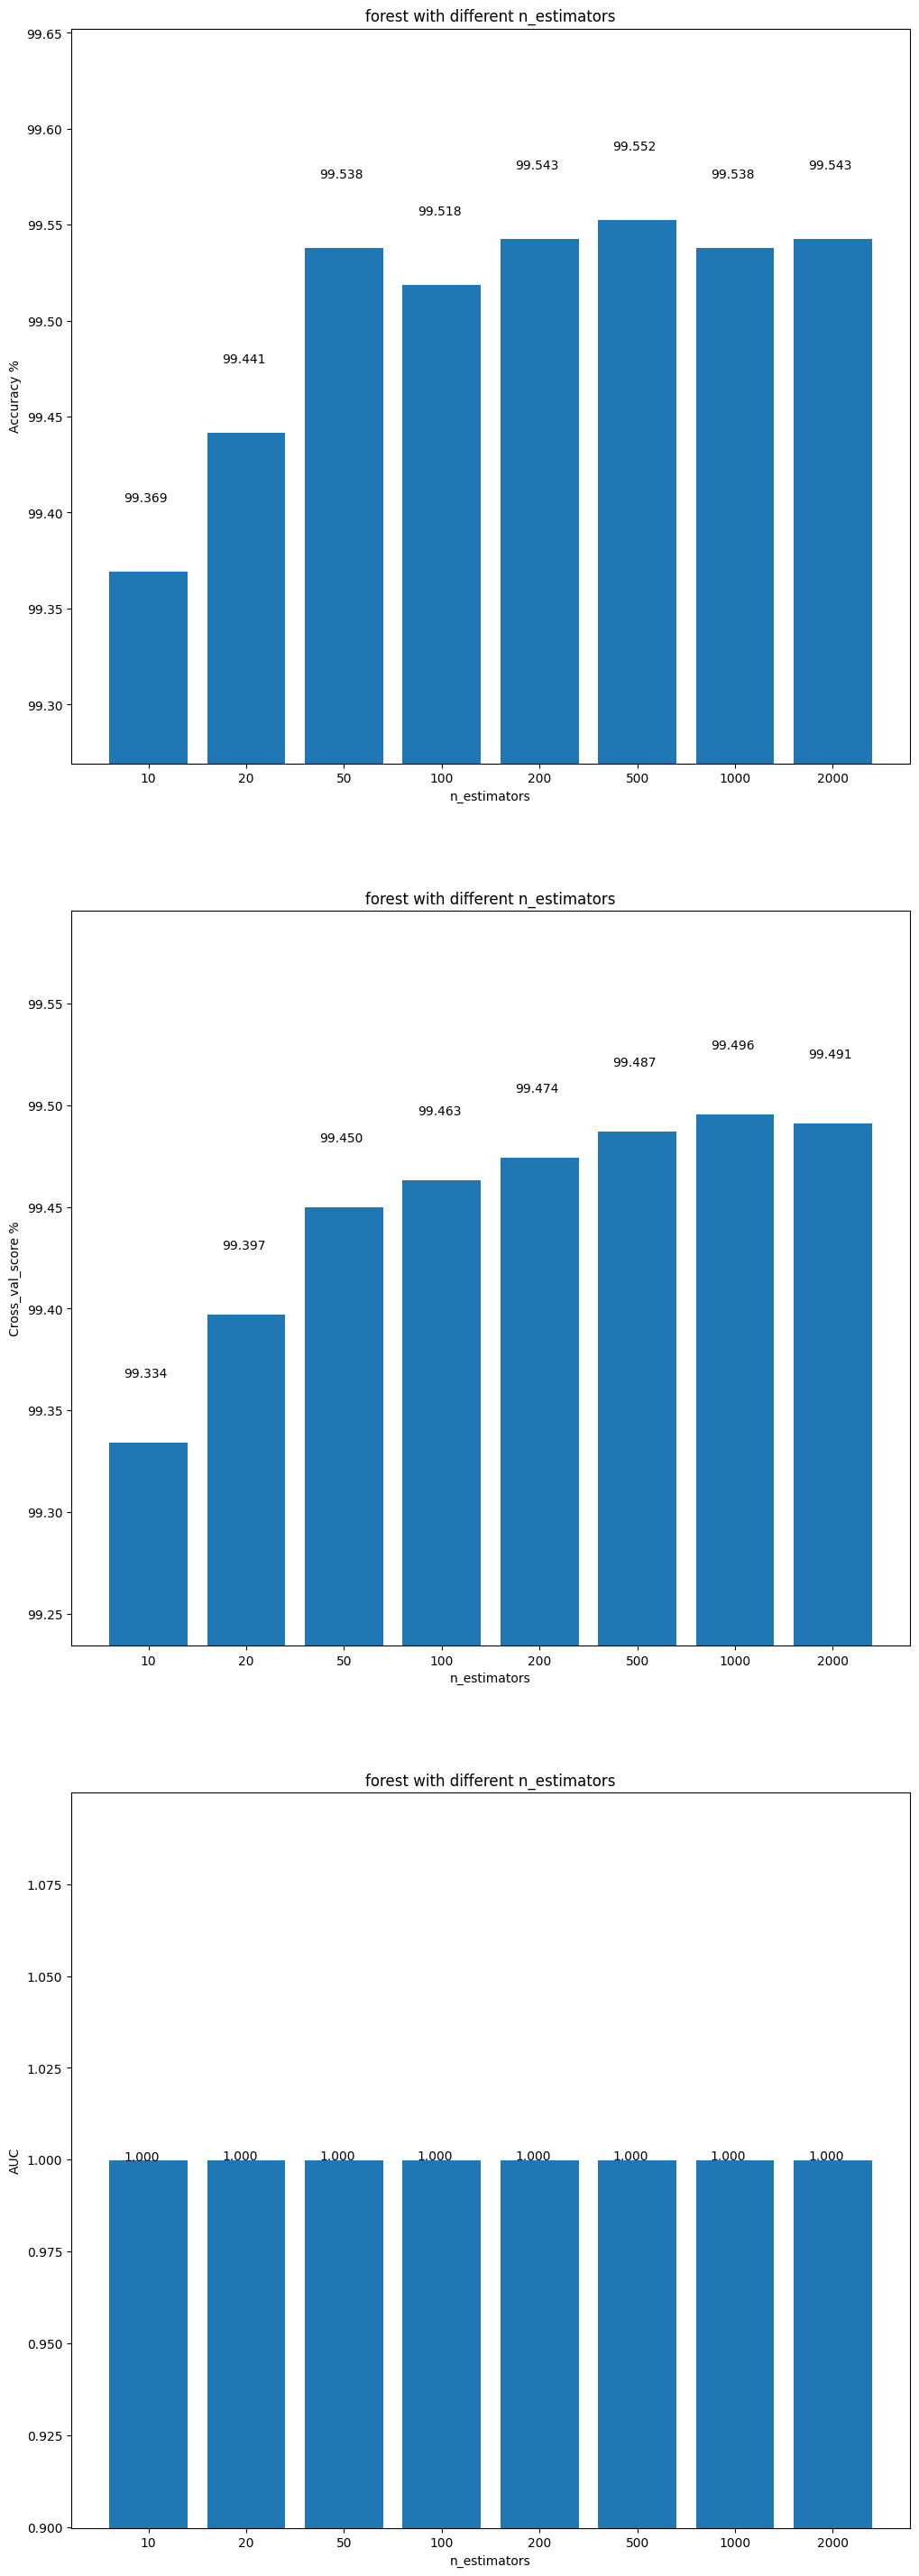

In [38]:
from sklearn.ensemble import RandomForestClassifier
n_estimators = [10,20,50,100,200,500,1000,2000]
accuracy_rfc_n = []
cross_val_score_rfc_n = []
auc_rfc_n = []
for n in n_estimators:
    forest = RandomForestClassifier(n_estimators=n)
    cross_val_score_rfc_n.append(cross_val_score(forest, X_train_ready, y_train, cv=kfold).mean()*100)
    
    forest.fit(X_train_ready, y_train)
    y_score = forest.predict_proba(X_test_ready)[:,1]
    y_pred = forest.predict(X_test_ready)
    accuracy_rfc_n.append(accuracy_score(y_test, y_pred)*100)
    auc_rfc_n.append(auc(roc_curve(y_test, y_score)[0:2][0], roc_curve(y_test, y_score)[0:2][1]))
    
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(12,36))

ax1.bar([str(n) for n in n_estimators], accuracy_rfc_n)
ax1.set_xlabel("n_estimators")
ax1.set_ylim(min(accuracy_rfc_n)-0.1, max(accuracy_rfc_n)+0.1)
ax1.set_ylabel("Accuracy %")
ax1.set_title("forest with different n_estimators")
for index,data in enumerate(accuracy_rfc_n):
    ax1.text(x=index-0.25 , y=data+(max(accuracy_rfc_n)-min(accuracy_rfc_n))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))

ax2.bar([str(n) for n in n_estimators], cross_val_score_rfc_n)
ax2.set_xlabel("n_estimators")
ax2.set_ylim(min(cross_val_score_rfc_n)-0.1, max(cross_val_score_rfc_n)+0.1)
ax2.set_ylabel("Cross_val_score %")
ax2.set_title("forest with different n_estimators")
for index,data in enumerate(cross_val_score_rfc_n):
    ax2.text(x=index-0.25 , y =data+(max(cross_val_score_rfc_n)-min(cross_val_score_rfc_n))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))


ax3.bar([str(n) for n in n_estimators], auc_rfc_n) 
ax3.set_xlabel("n_estimators")
ax3.set_ylim(min(auc_rfc_n)-0.1, max(auc_rfc_n)+0.1)
ax3.set_ylabel("AUC")
ax3.set_title("forest with different n_estimators")
for index,data in enumerate(auc_rfc_n):
    ax3.text(x=index-0.25 , y =data+(max(auc_rfc_n)-min(auc_rfc_n))/5 , s="%.3f" % data, fontdict=dict(fontsize=10))



plt.show()
    

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

nn = Sequential()
nn.add(Dense(64, input_shape=(34,)))
nn.add(Activation('relu'))
nn.add(Dropout(0.2))

nn.add(Dense(128))
nn.add(Activation('relu'))
nn.add(Dropout(0.2))

nn.add(Dense(128))
nn.add(Activation('relu'))
nn.add(Dropout(0.2))

nn.add(Dense(64))
nn.add(Activation('relu'))
nn.add(Dropout(0.2))

nn.add(Dense(2))
nn.add(Activation('softmax'))

nn.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
    )

In [ ]:
nn.fit(X_train_ready, to_categorical(y_train), epochs=100, validation_split=0.2)

In [ ]:
def plot_hist_acc(model, ax): 
    history = nn.history
    best_index = np.argmax(history.history['val_accuracy'])
    ax.plot(history.epoch, history.history['accuracy'], label='train')
    ax.plot(history.epoch, history.history['val_accuracy'], label='validation')
    ax.axvline(best_index, c='green', linestyle='dashed')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
plot_hist_acc(nn, ax)

<h1>User Interface</h1>

In [33]:
import pickle
import time

ddos = pd.read_csv("DDoS.csv")


In [32]:
class Droper:
    def __init__(self, axis):
        self.axis = axis
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        columns_with_null = X.isnull().any()
        features_with_null = columns_with_null[columns_with_null == True].index
        if self.axis == 0:
            return X.dropna(subset=features_with_null)
        if self.axis == 1:
            return X.drop(columns=features_with_null)

class AugmentData:
    def __init__(self):
        pass
    def separate(seperator, series):
        list = []
        for value in series:
            if value <= separator[0]:
                list.append(1)
            elif value <= separator[1]:
                list.append(2)
            elif value <= separator[2]:
                list.append(3)
            elif value <= separator[3]:
                list.append(4)
            else:
                list.append(5)
        return list
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        cut_line = np.linspace(0, X.shape[0], 6, dtype=int)
        rx_bytes_sorted = X['rx_bytes'].sort_values(ascending=True).to_numpy()
        separator = [rx_bytes_sorted[cut_line[1]], rx_bytes_sorted[cut_line[2]], rx_bytes_sorted[cut_line[3]], rx_bytes_sorted[cut_line[4]]]
        X['rx_bytes_cat'] = separate(separator, X['rx_bytes'])

        cut_line = np.linspace(0, ddos_dp.shape[0], 6, dtype=int)
        tx_bytes_sorted = ddos_dp['tx_bytes'].sort_values(ascending=True).to_numpy()
        separator = [tx_bytes_sorted[cut_line[1]], tx_bytes_sorted[cut_line[2]], tx_bytes_sorted[cut_line[3]], tx_bytes_sorted[cut_line[4]]]
        X['tx_bytes_cat'] = separate(separator, X['tx_bytes'])
        
        le = LabelEncoder()
        X['Protocol'] = le.fit_transform(X['Protocol'])
        
        return X



In [57]:
class Model:
    def __init__(self, data, drop_axis):
        augment = Pipeline([
            ('droper', Droper(axis=drop_axis)),
            ('data_augment', AugmentData())
        ])
        
        X = augment.fit_transform(data)
        y = X['label']
        X = X.drop(columns=['label'])
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
        
        selector = SelectKBest(k=10).fit(X_train.drop(columns=['src', 'dst', 'dt']), y_train)
        cols_idxs = selector.get_support(indices=True)
        X_train_best_features = X_train.drop(columns=['src', 'dst', 'dt']).iloc[:,cols_idxs]
        X_test_best_features = X_test.drop(columns=['src', 'dst', 'dt']).iloc[:,cols_idxs]
        
        num = Pipeline([
            ('scaler', StandardScaler())
        ])

        cat = Pipeline([
            ('one_hot', OneHotEncoder())
        ])

        categorical = ['Protocol', 'flows', 'rx_bytes_cat', 'tx_bytes_cat']
        numeric = ['pktcount', 'bytecount', 'dur', 'tot_dur', 'pktperflow', 'pktrate']

        preprocess = ColumnTransformer([
            ('cat', cat, categorical),
            ('num', num, numeric),
        ], remainder='passthrough')

        preprocess.fit(X_train_best_features)
        
        cat_columns = preprocess.named_transformers_['cat'].named_steps['one_hot'].get_feature_names_out(categorical)
        columns = np.append(cat_columns, numeric)
        
        X_train_ready = pd.DataFrame(preprocess.transform(X_train_best_features).toarray(), columns=columns)
        X_test_ready = pd.DataFrame(preprocess.transform(X_test_best_features).toarray(), columns=columns)
        
        self.X_train = X_train_ready
        self.X_test = X_test_ready
        self.y_train = y_train
        self.y_test = y_test
    
    def RandomForest(self):
        start_time = time.time()
        RF = RandomForestClassifier(criterion='gini',
                                     n_estimators=500,
                                     min_samples_split=10,
                                     max_features='auto',
                                     oob_score=True,
                                     random_state=1,
                                     n_jobs=-1).fit(self.X_train, self.y_train)
                # Save the trained Random Forest model and the StandardScaler to files
        model_filename = 'random_forest_model.pkl'
        
        with open(model_filename,'wb') as f:
            pickle.dump(RF,f)



        predicted_rf = RF.predict(self.X_test)
        rf_accuracy = accuracy_score(self.y_test, predicted_rf)
        models['Random Forest'] = rf_accuracy
        print(f"Accuracy of RF is : {round(rf_accuracy*100,2)}%", '\n')
        print("########################################################################")
        print(classification_report(predicted_rf, self.y_test))
        print("########################################################################")

        print("--- %s seconds ---" % (time.time() - start_time))
    

In [58]:
M = Model(ddos, 0)

In [59]:
M.RandomForest()

Accuracy of RF is : 99.43% 

########################################################################
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     12589
           1       0.99      0.99      0.99      8179

    accuracy                           0.99     20768
   macro avg       0.99      0.99      0.99     20768
weighted avg       0.99      0.99      0.99     20768

########################################################################
--- 5.47934103012085 seconds ---


In [39]:
ddos

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,3,3413,3665,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104340,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,10,29,2842,0,0,ICMP,1,15209,12720,1,1.0,2.0,0
104341,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,10,29,2842,0,0,ICMP,3,15099,14693,1,1.0,2.0,0
104342,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,0,ICMP,2,3409,3731,0,0.0,0.0,0
104343,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,0,ICMP,1,15209,12720,1,1.0,2.0,0


In [34]:
import pickle
import time
from sklearn.metrics import classification_report
class Model:
    global y
    global models
    models = {}
    def __init__(self, data):
        self.data = data
        self.scaler = StandardScaler().fit(self.data)  # Fit the StandardScaler
        X = self.scaler.transform(self.data)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state=42, test_size=0.3)

    def RandomForest(self):
        start_time = time.time()
        RF = RandomForestClassifier(criterion='gini',
                                     n_estimators=500,
                                     min_samples_split=10,
                                     #min_samples_leaf=1,
                                     max_features='auto',
                                     oob_score=True,
                                     random_state=1,
                                     n_jobs=-1).fit(self.X_train, self.y_train)
                # Save the trained Random Forest model and the StandardScaler to files
        model_filename = 'random_forest_model.pkl'
        scaler_filename = 'standard_scaler.pkl'

                # save
        with open(model_filename,'wb') as f:
            pickle.dump(RF,f)

        with open(scaler_filename,'wb') as f:
            pickle.dump(self.scaler,f)



        predicted_rf = RF.predict(self.X_test)
        rf_accuracy = accuracy_score(self.y_test, predicted_rf)
        models['Random Forest'] = rf_accuracy
        print(f"Accuracy of RF is : {round(rf_accuracy*100,2)}%", '\n')
        print("########################################################################")
        print(classification_report(predicted_rf, self.y_test))
        print("########################################################################")

        print("--- %s seconds ---" % (time.time() - start_time))


In [35]:
df = ddos.copy()
df = df.dropna()
X = df.drop(['dt','src','dst','label'], axis=1)
y = df.label
X = pd.get_dummies(X)

In [36]:
M = Model(X)
M.RandomForest()

Accuracy of RF is : 99.99% 

########################################################################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18984
           1       1.00      1.00      1.00     12168

    accuracy                           1.00     31152
   macro avg       1.00      1.00      1.00     31152
weighted avg       1.00      1.00      1.00     31152

########################################################################
--- 5.751338958740234 seconds ---


In [67]:
X

,switch,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,Protocol_ICMP,Protocol_TCP,Protocol_UDP
0,1,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,3,143928631,3917,0,0.0,0.0,0,0,1
1,1,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,451,0,4,3842,3520,0,0.0,0.0,0,0,1
2,1,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,1,3795,1242,0,0.0,0.0,0,0,1
3,1,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,2,3688,1492,0,0.0,0.0,0,0,1
4,1,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,3,3413,3665,0,0.0,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104340,3,79,7742,81,842000000,8.184200e+10,5,10,29,2842,0,0,1,15209,12720,1,1.0,2.0,1,0,0
104341,3,79,7742,81,842000000,8.184200e+10,5,10,29,2842,0,0,3,15099,14693,1,1.0,2.0,1,0,0
104342,3,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,0,2,3409,3731,0,0.0,0.0,1,0,0
104343,3,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,0,1,15209,12720,1,1.0,2.0,1,0,0


In [109]:
ddos

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,3,3413,3665,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104340,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,10,29,2842,0,0,ICMP,1,15209,12720,1,1.0,2.0,0
104341,5262,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,10,29,2842,0,0,ICMP,3,15099,14693,1,1.0,2.0,0
104342,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,0,ICMP,2,3409,3731,0,0.0,0.0,0
104343,5262,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,0,ICMP,1,15209,12720,1,1.0,2.0,0


## **Create pcap file:**

In [37]:
malicious = ddos[ddos['label'] == 1].values[1:10, :-1]
malicious

array([[11335, 1, '10.0.0.1', '10.0.0.8', 4777, 5092282, 10, 711000000,
        10711000000.0, 3, 1790, 0, 0, 0, 0, 'UDP', 3, 3679, 58460931, 0,
        5232.0, 5232.0],
       [11335, 1, '10.0.0.1', '10.0.0.8', 4777, 5092282, 10, 711000000,
        10711000000.0, 3, 1790, 0, 0, 0, 0, 'UDP', 2, 3733, 1402, 0, 0.0,
        0.0],
       [11335, 1, '10.0.0.1', '10.0.0.8', 4777, 5092282, 10, 711000000,
        10711000000.0, 3, 1790, 0, 0, 0, 0, 'UDP', 4, 58460931, 3749,
        5232, 0.0, 5232.0],
       [11335, 1, '10.0.0.1', '10.0.0.8', 4777, 5092282, 10, 711000000,
        10711000000.0, 3, 1790, 0, 0, 0, 0, 'UDP', 3, 3413, 3623, 0, 0.0,
        0.0],
       [11335, 1, '10.0.0.1', '10.0.0.8', 4777, 5092282, 10, 711000000,
        10711000000.0, 3, 1790, 0, 0, 0, 0, 'UDP', 2, 3683, 1422, 0, 0.0,
        0.0],
       [11335, 1, '10.0.0.1', '10.0.0.8', 4777, 5092282, 10, 711000000,
        10711000000.0, 3, 1790, 0, 0, 0, 0, 'UDP', 1, 3733, 1172, 0, 0.0,
        0.0],
       [11335, 1, '1

In [38]:
benign = ddos[ddos['label'] == 0].values[1:10, :-1]
benign

array([[11605, 1, '10.0.0.1', '10.0.0.8', 126395, 134737070, 280,
        734000000, 281000000000.0, 2, 1943, 13531, 14424046, 451, 0,
        'UDP', 4, 3842, 3520, 0, 0.0, 0.0],
       [11425, 1, '10.0.0.2', '10.0.0.8', 90333, 96294978, 200,
        744000000, 201000000000.0, 3, 1943, 13534, 14427244, 451, 0,
        'UDP', 1, 3795, 1242, 0, 0.0, 0.0],
       [11425, 1, '10.0.0.2', '10.0.0.8', 90333, 96294978, 200,
        744000000, 201000000000.0, 3, 1943, 13534, 14427244, 451, 0,
        'UDP', 2, 3688, 1492, 0, 0.0, 0.0],
       [11425, 1, '10.0.0.2', '10.0.0.8', 90333, 96294978, 200,
        744000000, 201000000000.0, 3, 1943, 13534, 14427244, 451, 0,
        'UDP', 3, 3413, 3665, 0, 0.0, 0.0],
       [11425, 1, '10.0.0.2', '10.0.0.8', 90333, 96294978, 200,
        744000000, 201000000000.0, 3, 1943, 13534, 14427244, 451, 0,
        'UDP', 1, 3795, 1402, 0, 0.0, 0.0],
       [11425, 1, '10.0.0.1', '10.0.0.8', 45304, 48294064, 100,
        716000000, 101000000000.0, 3, 1943, 13535

In [39]:
from scapy.all import *
import struct

def create_pcap_file(filename, dataset):

    custom_packets = []
    
    for data in dataset:
        
        # Define values for the features
        dt = data[0]
        switch = data[1]
        src = data[2]
        dst = data[3]
        pktcount = data[4]
        bytecount = data[5]
        dur = data[6]
        dur_nsec =data[7]
        tot_dur = data[8]
        flows = data[9]
        packetins = data[10]
        pktperflow = data[11]
        byteperflow = data[12]
        pktrate = data[13]
        Pairflow = data[14]
        Protocol = data[15]
        port_no = data[16]
        tx_bytes = data[17]
        rx_bytes = data[18]
        tx_kbps = data[19]
        rx_kbps = data[20]
        tot_kbps = data[21]
        
        # Create a custom packet with all the features
        custom_packet = Ether() / IP(src=src, dst=dst) / \
            Raw(struct.pack(">I", dt) + \
              struct.pack(">I", switch) + \
              bytes(src, "utf-8") + b"\x00" * (16 - len(src)) + \
              bytes(dst, "utf-8") + b"\x00" * (16 - len(dst)) + \
              struct.pack(">I", pktcount) + \
              struct.pack(">I", bytecount) + \
              struct.pack(">f", dur) + \
              struct.pack(">I", dur_nsec) + \
              struct.pack(">f", tot_dur) + \
              struct.pack(">I", flows) + \
              struct.pack(">I", packetins) + \
              struct.pack(">I", pktperflow) + \
              struct.pack(">I", byteperflow) + \
              struct.pack(">I", pktrate) + \
              struct.pack(">I", Pairflow) + \
              bytes(Protocol, "utf-8") + b"\x00" * (16 - len(Protocol)) + \
              struct.pack(">H", port_no) + \
              struct.pack(">I", tx_bytes) + \
              struct.pack(">I", rx_bytes) + \
              struct.pack(">I", tx_kbps) + \
              struct.pack(">f", rx_kbps) + \
              struct.pack(">f", tot_kbps))
        custom_packets.append(custom_packet)

  # Save the custom packet as a PCAP
    wrpcap(filename, custom_packets)

    print("Custom packet with features saved to " + filename)


In [40]:
create_pcap_file(filename = 'malicious.pcap', dataset= malicious )
create_pcap_file(filename = 'benign.pcap', dataset= benign )

Custom packet with features saved to malicious.pcap
Custom packet with features saved to benign.pcap


In [41]:
import pandas as pd
from scapy.all import *
import struct
import warnings
warnings.filterwarnings("ignore")
import joblib
import pickle

def load_model():
    model_filename = 'random_forest_model.pkl'
    scaler_filename= 'standard_scaler.pkl'
    # load
    with open(model_filename, 'rb') as f:
        loaded_model = pickle.load(f)
    with open(scaler_filename, 'rb') as f:
        loaded_scaler = pickle.load(f)
    return loaded_model,loaded_scaler

loaded_model,loaded_scaler = load_model()

def predict(packet_filename):
    # Load packets from the custom PCAP file
    packets = rdpcap(packet_filename)

    # Initialize an empty list to store the extracted data
    data_list = []

    # Iterate through each packet and extract the necessary fields
    for packet in packets:
        if Raw in packet:
            raw_layer = packet[Raw].load

            dt = struct.unpack(">I", raw_layer[:4])[0]
            switch = struct.unpack(">I", raw_layer[4:8])[0]
            src = raw_layer[8:24].rstrip(b'\x00').decode("utf-8")
            dst = raw_layer[24:40].rstrip(b'\x00').decode("utf-8")
            pktcount = struct.unpack(">I", raw_layer[40:44])[0]
            bytecount = struct.unpack(">I", raw_layer[44:48])[0]
            dur = struct.unpack(">f", raw_layer[48:52])[0]
            dur_nsec = struct.unpack(">I", raw_layer[52:56])[0]
            tot_dur = struct.unpack(">f", raw_layer[56:60])[0]
            flows = struct.unpack(">I", raw_layer[60:64])[0]
            packetins = struct.unpack(">I", raw_layer[64:68])[0]
            pktperflow = struct.unpack(">I", raw_layer[68:72])[0]
            byteperflow = struct.unpack(">I", raw_layer[72:76])[0]
            pktrate = struct.unpack(">I", raw_layer[76:80])[0]
            Pairflow = struct.unpack(">I", raw_layer[80:84])[0]
            Protocol = raw_layer[84:100].rstrip(b'\x00').decode("utf-8")
            port_no = struct.unpack(">H", raw_layer[100:102])[0]
            tx_bytes = struct.unpack(">I", raw_layer[102:106])[0]
            rx_bytes = struct.unpack(">I", raw_layer[106:110])[0]
            tx_kbps = struct.unpack(">I", raw_layer[110:114])[0]
            rx_kbps = struct.unpack(">I", raw_layer[114:118])[0]
            tot_kbps = struct.unpack(">I", raw_layer[118:122])[0]


          # Create a dictionary with the extracted fields
            data_dict = {
                'dt': dt,
                'switch': switch,
                'src': src,
                'dst': dst,
                'pktcount': pktcount,
                'bytecount': bytecount,
                'dur': dur,
                'dur_nsec': dur_nsec,
                'tot_dur': tot_dur,
                'flows': flows,
                'packetins': packetins,
                'pktperflow': pktperflow,
                'byteperflow': byteperflow,
                'pktrate': pktrate,
                'Pairflow': Pairflow,
                'Protocol_ICMP': 1 if Protocol == 'ICMP' else 0,
                'Protocol_TCP': 1 if Protocol == 'TCP' else 0,
                'Protocol_UDP': 1 if Protocol == 'UDP' else 0,
                'port_no': port_no,
                'tx_bytes': tx_bytes,
                'rx_bytes': rx_bytes,
                'tx_kbps': tx_kbps,
                'rx_kbps': rx_kbps,
                'tot_kbps': tot_kbps,
            }

            # Append the dictionary to the data list
            data_list.append(data_dict)

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data_list)
    src = df['src']
    dst = df['dst']
    # Get the feature names used during training
    original_feature_names = loaded_scaler.feature_names_in_
#     # Now, 'df' contains the extracted fields in the same order as your desired DataFrame
#     print(df)
    labels = ["The request is NOT a DDOS attack", "The request is likely a DDOS attack"]
    X = df.drop(['dt', 'src', 'dst'], axis=1)
    
    # Rearrange the columns in 'X' to match the original feature order
    X_reordered = X[original_feature_names]

    # Transform the new data using the loaded scaler
    scaled_new_data = loaded_scaler.transform(X_reordered)

    # Ensure that the column names match the feature names
    scaled_new_df = pd.DataFrame(scaled_new_data, columns=original_feature_names)

    # Predict using the loaded model
    predicted_labels = loaded_model.predict(scaled_new_df)

    # Print the predicted labels
    return [[src_ip, dst_ip, labels[prediction]] for src_ip, dst_ip, prediction in zip(src,dst,predicted_labels)]

In [42]:
predict('malicious.pcap')

[['10.0.0.1', '10.0.0.8', 'The request is likely a DDOS attack'],
 ['10.0.0.1', '10.0.0.8', 'The request is likely a DDOS attack'],
 ['10.0.0.1', '10.0.0.8', 'The request is likely a DDOS attack'],
 ['10.0.0.1', '10.0.0.8', 'The request is likely a DDOS attack'],
 ['10.0.0.1', '10.0.0.8', 'The request is likely a DDOS attack'],
 ['10.0.0.1', '10.0.0.8', 'The request is likely a DDOS attack'],
 ['10.0.0.1', '10.0.0.8', 'The request is likely a DDOS attack'],
 ['10.0.0.1', '10.0.0.8', 'The request is likely a DDOS attack'],
 ['10.0.0.1', '10.0.0.8', 'The request is likely a DDOS attack']]

In [43]:
predict('benign.pcap')

[['10.0.0.1', '10.0.0.8', 'The request is NOT a DDOS attack'],
 ['10.0.0.2', '10.0.0.8', 'The request is NOT a DDOS attack'],
 ['10.0.0.2', '10.0.0.8', 'The request is NOT a DDOS attack'],
 ['10.0.0.2', '10.0.0.8', 'The request is NOT a DDOS attack'],
 ['10.0.0.2', '10.0.0.8', 'The request is NOT a DDOS attack'],
 ['10.0.0.1', '10.0.0.8', 'The request is NOT a DDOS attack'],
 ['10.0.0.1', '10.0.0.8', 'The request is NOT a DDOS attack'],
 ['10.0.0.1', '10.0.0.8', 'The request is NOT a DDOS attack'],
 ['10.0.0.2', '10.0.0.8', 'The request is NOT a DDOS attack']]

In [119]:
random = ddos.sample(n=20)
random_X = random.values[:, :-1]
random_y = random.values[:, -1]
random_X, random_y

(array([[10056, 1, '10.0.0.1', '10.0.0.7', 100347, 106969902, 223,
         260000000, 223000000000.0, 2, 1931, 13308, 14186328, 443, 0,
         'UDP', 2, 3719, 1242, 0, 0.0, 0.0],
        [24821, 4, '10.0.0.14', '10.0.0.4', 92301, 4984254, 326, 39000000,
         326000000000.0, 5, 10817, 8292, 447768, 276, 1, 'TCP', 4,
         16683115, 159539743, 258, 360.0, 618.0],
        [3939, 4, '10.0.0.7', '10.0.0.5', 75156, 80116296, 166, 679000000,
         167000000000.0, 3, 8803, 13430, 14316380, 447, 0, 'UDP', 3,
         700128421, 5951, 0, 0.0, 0.0],
        [30823, 4, '10.0.0.9', '10.0.0.4', 31858, 1720332, 100, 278000000,
         100000000000.0, 7, 3982, 9305, 502470, 310, 1, 'TCP', 2, 5073,
         1242, 0, 0.0, 0.0],
        [24911, 5, '10.0.0.4', '10.0.0.14', 121339, 7037662, 428,
         780000000, 429000000000.0, 5, 10817, 8407, 487606, 280, 1, 'TCP',
         3, 163471110, 19498508, 361, 258.0, 619.0],
        [32913, 1, '10.0.0.1', '10.0.0.3', 545, 53410, 558, 548000000,
 

In [145]:
create_pcap_file('random.pcap', dataset=random_X)
predict('random.pcap')

Custom packet with features saved to random.pcap


[['10.0.0.1', '10.0.0.7', 'Benign'],
 ['10.0.0.14', '10.0.0.4', 'Malicious'],
 ['10.0.0.7', '10.0.0.5', 'Benign'],
 ['10.0.0.9', '10.0.0.4', 'Malicious'],
 ['10.0.0.4', '10.0.0.14', 'Malicious'],
 ['10.0.0.1', '10.0.0.3', 'Benign'],
 ['10.0.0.3', '10.0.0.15', 'Benign'],
 ['10.0.0.5', '10.0.0.12', 'Malicious'],
 ['10.0.0.18', '10.0.0.7', 'Malicious'],
 ['10.0.0.6', '10.0.0.10', 'Benign'],
 ['10.0.0.1', '10.0.0.8', 'Benign'],
 ['10.0.0.12', '10.0.0.5', 'Benign'],
 ['10.0.0.8', '10.0.0.9', 'Benign'],
 ['10.0.0.14', '10.0.0.10', 'Malicious'],
 ['10.0.0.4', '10.0.0.8', 'Malicious'],
 ['10.0.0.2', '10.0.0.8', 'Malicious'],
 ['10.0.0.4', '10.0.0.8', 'Malicious'],
 ['10.0.0.3', '10.0.0.16', 'Benign'],
 ['10.0.0.12', '10.0.0.7', 'Malicious'],
 ['10.0.0.1', '10.0.0.7', 'Malicious']]

In [146]:
# If found malicious packets, block the src ip address:

# use block() pseudo-function

results = predict('random.pcap')



In [ ]:
# for result in results:
#     if result[2] == 'Malicious':
#         block(result[0])